In [1]:
from pathlib import Path
from rosbags.highlevel import AnyReader
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
import pandas as pd

# ---------------- setup ----------------
# bagpath = Path("../braking_files/regen_brake_bags/day_2_23m_v22.bag")
bagpath = Path("day_3_trail3_v5.bag")

typestore = get_typestore(Stores.ROS2_JAZZY)


with AnyReader([bagpath]) as reader:
    topics = sorted({c.topic for c in reader.connections})

for t in topics:
    print(t)
    
    
required_topics = {
    # '/fixposition/odometry_ecef',
    # '/motor_feedback',
    # '/steering_pub',
    # '/fixposition/odometry_smooth',
    # '/fixposition/odometry_ecef',
    # '/fixposition/imu_ypr',
    # '/fixposition/fpa/rawimu',
    '/fixposition/fpa/odomenu'
    
}

# ---------------- read bag ----------------
with AnyReader([bagpath], default_typestore=typestore) as reader:
    connections = [c for c in reader.connections if c.topic in required_topics]
    
    print(connections[-1])

    for c, t, raw in reader.messages(connections=connections):
        msg = reader.deserialize(raw, c.msgtype)
        print(msg)
        break

/fixposition/fpa/corrimu
/fixposition/fpa/odomenu
/fixposition/fpa/odometry
/fixposition/fpa/odomsh
/fixposition/fpa/rawimu
/fixposition/imu_ypr
/fixposition/nmea/gga
/fixposition/odometry_ecef
/fixposition/odometry_enu
/fixposition/odometry_enu_smooth
/fixposition/odometry_llh
/fixposition/odometry_smooth
/fixposition/poiimu
/fixposition/ypr
/motor_feedback
/rosout
/rosout_agg
/steering_pub
/tf
/tf_static
Connection(id=8, topic='/fixposition/fpa/odomenu', msgtype='fixposition_driver_msgs/msg/FpaOdomenu', msgdef=MessageDefinition(format=<MessageDefinitionFormat.MSG: 1>, data="# Copyright (c) Fixposition AG (www.fixposition.com) and contributors\n# License: see the LICENSE file\n#\n# FP_A-ODOMENU data\n\nstd_msgs/Header header\nstring pose_frame                            # frame of the pose values (pose, quaternion)\nstring kin_frame                             # frame of the kinematic values (linear and angular velocity, acceleration)\ngeometry_msgs/PoseWithCovariance pose        # po

## To do 
First need to filter the yaw proper -- seems like we will need kalman filter - because within small time frame yaw jumps up really high and comes back 

Cut the data set into sections - with
i - constant velocity 
ii - 0 velocity 
iii - ramps  +ve and -ve 

then try to fit parameters for each section seperately 


We need to do fft on torque and check -- high freq response will correspond to J and b?? 

Also we can remove very high freq noises 



In [91]:
# !pip install scikit-learn --quiet
# import sys, subprocess
# print(sys.executable)
# !which pip

# import sys
# !{sys.executable} -m pip install scikit-optimize

In [2]:
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
import pandas as pd

import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

#---------- PARAMS -----------
KT = 0.199  # motors torque constant
POLE_PAIR = 21
GR = 8

# ---------------- setup ----------------
bagpath = Path("./day_3_trail3_v5.bag")
typestore = get_typestore(Stores.ROS2_JAZZY)



transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

required_topics = {
    '/fixposition/fpa/odomenu',
    '/motor_feedback',
    '/steering_pub'
}

rows = []

if not bagpath.exists():
    print(f"dude common ")
    exit
# ---------------- read bag ----------------
with AnyReader([bagpath], default_typestore=typestore) as reader:
    connections = [c for c in reader.connections if c.topic in required_topics]

    for c, t, raw in reader.messages(connections=connections):

        msg = reader.deserialize(raw, c.msgtype)
        time = t * 1e-9  # ns → seconds
        time = datetime.fromtimestamp(time)

        row = {"time": time}

        # -------- odometry --------
        if c.topic == '/fixposition/fpa/odomenu':
            p = msg.pose.pose.position
            q = msg.pose.pose.orientation
            v = msg.velocity.twist.linear
            w = msg.velocity.twist.angular

            lon, lat, alt = transformer.transform(p.x, p.y, p.z)
            yaw, pitch, roll = R.from_quat(
                [q.x, q.y, q.z, q.w]
            ).as_euler("zyx", degrees=True)
            

            row.update({
                "lat": lat,
                "lon": lon,
                "alt": alt,
                "yaw": yaw,
                "pitch": pitch,
                "roll": roll,
                "vx":v.x,
                "vy":v.y,
                "vz":v.z,
                "v_speed": (v.x**2 + v.y**2) ** 0.5,
                "yaw_rate": w.x, 
                "pitch_rate": w.y,
                "roll_rate": w.z
                # "body_x": v_body[0],
                # "body_y": v_body[1],
                # "body_z": v_body[2]
            })

        # -------- motor feedback --------
        if c.topic == '/motor_feedback':
            row.update({
                "pos": msg.data[0],
                "rpm": msg.data[1]*(POLE_PAIR*GR),
                "torque": msg.data[2]*KT,
                "temp": msg.data[3],
                "err": msg.data[4]
            })

        # -------- steering --------
        if c.topic == '/steering_pub':
            row.update({
                "steering_vel": msg.linear.x
            })

        rows.append(row)

# ---------------- dataframe ----------------

df = pd.DataFrame(rows)  #.sort_values("time")
t0 = df["time"].iloc[0]
df["time"] = df["time"] - t0
# df["dt"] = df["t_rel"].diff()

# Resampled data frame 
df = df.set_index("time").resample("100ms").mean().interpolate()
df.yaw = df.yaw*np.pi/180
df['uncorrect_yaw'] = df.yaw
df.yaw = np.unwrap(df.yaw)


DT = 0.1

## Check the data
# df.head()
# df.isna().sum()
# df.resample("100ms").mean().interpolate().isna().sum()

# ploting_df[plt_col].loc["00:00:00":"00:11:05"].plot(figsize=(20,8))


<Axes: xlabel='time'>

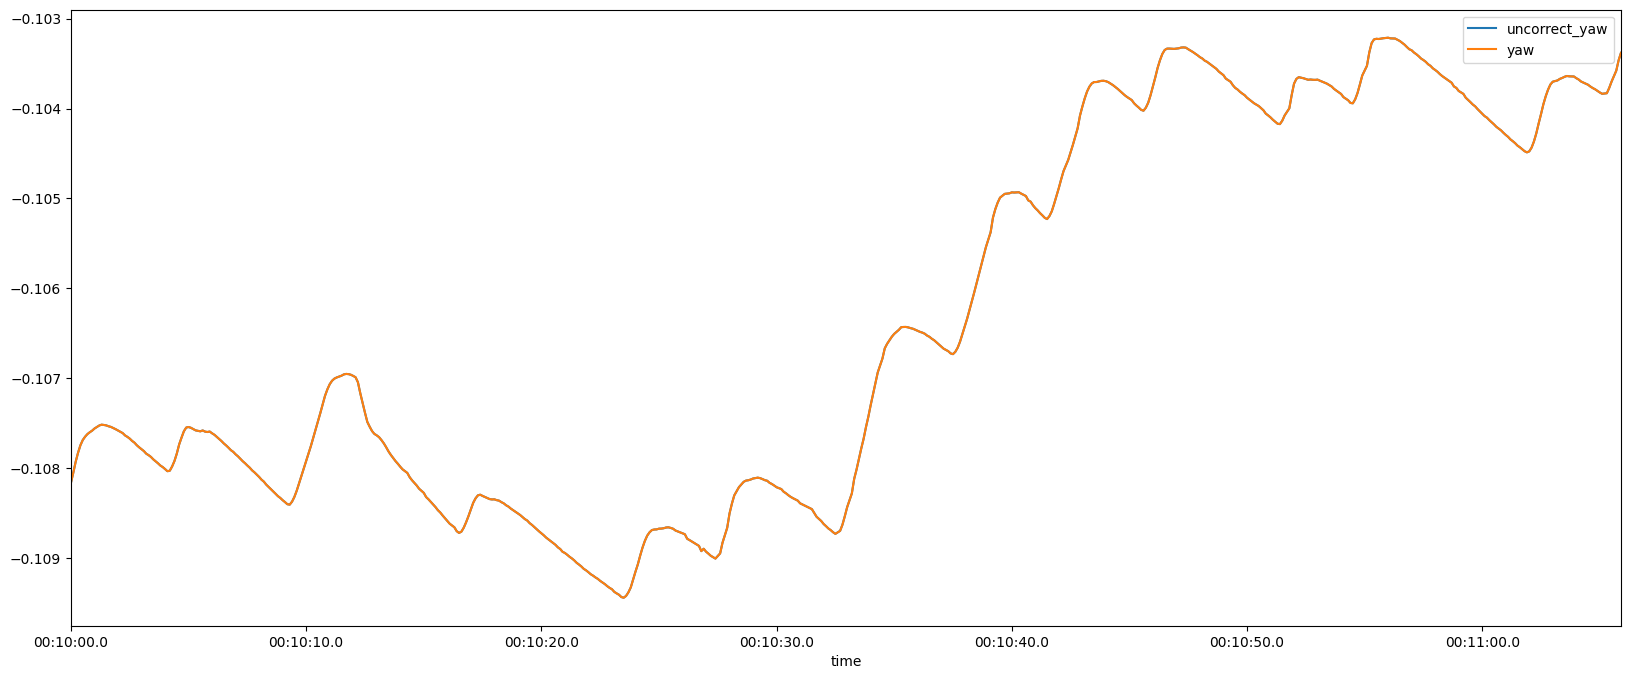

In [4]:
# ploting_df = df.resample("100ms").nearest()
ploting_df = df.copy()
# ploting_df.interpolate(method='linear', inplace=True)
# ploting_df.index.to_series().diff().describe()


drop_col = ['alt' , 'err' ,'lon','lat','pos' , 'temp' , ]
include_col   = ['yaw', 'vx']    #= ['vx' , 'vy' , 'yaw' , 'pitch' , 'roll']

ploting_df.drop(drop_col, axis=1, inplace=True)
# ploting_df = ploting_df[include_col]

# ploting_df.steering_vel = ploting_df.steering_vel/1000

# ploting_df.drop(['time'], axis=1 , inplace=True)

ploting_df.yaw = ploting_df.yaw*np.pi/180
ploting_df['uncorrect_yaw'] = ploting_df.yaw
ploting_df.yaw = np.unwrap(ploting_df.yaw)
ploting_df.rpm = ploting_df.rpm/100000
ploting_df.steering_vel = ploting_df.steering_vel/1000

plt_col = ['uncorrect_yaw' , 'yaw']

# ploting_df.iloc[-450:-400].plot(kind='line' , figsize=(20,8))
ploting_df[plt_col].loc["00:10:00":"00:11:05"].plot(figsize=(20,8))

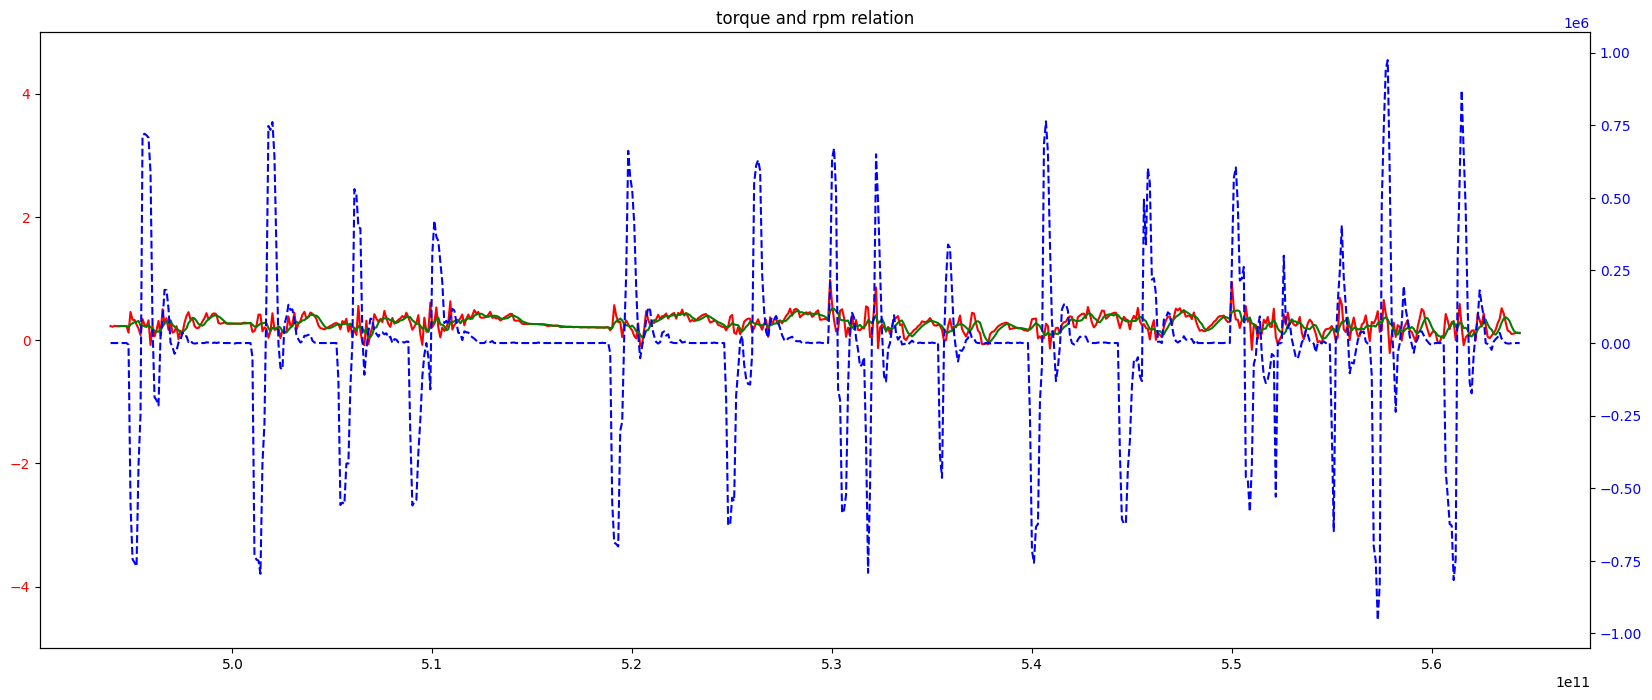

In [180]:
x = df.shape[0]
i = 7
plot_data = df.iloc[int(x*i/10) : int(x*(i+1)/10)]

fig , ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
# Plot data on the first axes (left subplot)
ax.plot(plot_data.torque, 'r-' , label = 'current')
ax.plot(plot_data.torque.rolling(window=5).mean() , 'g' , label = 'rolling current')
ax.set_ylim(-5 , 5)
# Plot data on the second axes (right subplot)
ax2.plot(plot_data.rpm, 'b--' , label= 'rpm')

# 6. Customize tick colors to match the line colors for clarity
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')

# 7. Add a title and show the plot
plt.title('torque and rpm relation')
plt.show()

In [ ]:
cols = ['torque' , 'rpm' , 'yaw' , 'pos']
check_df = df[cols]
check_df['yaw_rate'] = df.yaw.diff()/DT
check_df['rpm_rate'] = df.rpm.diff()/DT
cov = check_df.corr()
print(cov)

            torque       rpm       yaw       pos  yaw_rate  rpm_rate
torque    1.000000  0.015785 -0.064046  0.098286  0.015666  0.022730
rpm       0.015785  1.000000 -0.064694  0.014194  0.009677  0.272109
yaw      -0.064046 -0.064694  1.000000  0.065249  0.076927 -0.005774
pos       0.098286  0.014194  0.065249  1.000000  0.033480 -0.139413
yaw_rate  0.015666  0.009677  0.076927  0.033480  1.000000 -0.019032
rpm_rate  0.022730  0.272109 -0.005774 -0.139413 -0.019032  1.000000


## Plain ML

In [181]:
# Fitting least square regression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

data = df.dropna(axis=0, how='any')
data = (data - data.mean())/data.std()

y = data.torque
X = data.drop(columns=['torque'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

from sklearn.linear_model import LinearRegression

regressor = LinearRegression().fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 1.02
Coefficient of determination: -0.74


In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

data = df.dropna(axis=0, how='any')
data = (data - data.mean())/data.std()

y = data.torque
X = data.drop(columns=['torque'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

def train_augment(df : pd.DataFrame):
    
    beta_data = np.arctan(data['vy'] / (data['vx'])).rolling(window = 2 , min_periods=1).mean()
    beta_std = beta_data.std()
    beta_data = beta_data/beta_std

    # yaw_term_data = data['yaw_rate'] / (data['v_speed'] + 1e-6)
    yaw_term_data = data['yaw'].diff().bfill()/DT / (data['v_speed'] + 1e-6)
    yaw_term_std = yaw_term_data.std()
    yaw_term_data = yaw_term_data/ yaw_term_std

    pos_data = data['pos']*np.pi/180

    steering_spd = data['rpm']
    steering_spd_std = steering_spd.std()
    steering_spd = steering_spd/ steering_spd_std

    steering_acel = data['rpm'].diff()
    steering_acel_std = steering_acel.std()
    steering_acel = steering_acel / steering_acel_std
    
    df['beta'] = beta_data
    df['yaw_term'] = yaw_term_data
    df['pos'] = pos_data
    df['steering_spd'] = steering_spd
    df['steering_acel'] = steering_acel
    
    return df , beta_std , yaw_term_std , steering_spd_std , steering_acel_std

def test_augment( df: pd.DataFrame ,beta_std , yaw_term_std , steering_spd_std , steering_acel_std ):
    beta_data = np.arctan(data['vy'] / (data['vx'])).rolling(window = 2 , min_periods=1).mean()
    beta_data = beta_data/beta_std

    # yaw_term_data = data['yaw_rate'] / (data['v_speed'] + 1e-6)
    yaw_term_data = data['yaw'].diff().bfill()/DT / (data['v_speed'] + 1e-6)
    yaw_term_data = yaw_term_data/ yaw_term_std

    pos_data = data['pos']*np.pi/180

    steering_spd = data['rpm']
    steering_spd = steering_spd/ steering_spd_std

    steering_acel = data['rpm'].diff()
    steering_acel = steering_acel / steering_acel_std
    
    df['beta'] = beta_data
    df['yaw_term'] = yaw_term_data
    df['pos'] = pos_data
    df['steering_spd'] = steering_spd
    df['steering_acel'] = steering_acel
    
    return df

X_train , beta_std , yaw_term_std , steering_spd_std , steering_acel_std = train_augment(X_train)
X_train = X_train.bfill().interpolate()
X_test = test_augment(X_test , beta_std , yaw_term_std , steering_spd_std , steering_acel_std).bfill().interpolate()

# data , _ , _ , _ , _ = train_augment(data)
# data.to_csv('steering_data.csv')

print(f"shape of train {X_train.shape}  test {X_test.shape}")
pls2 = PLSRegression(n_components=2)
pls2.fit(X_train, y_train)
PLSRegression()
y_pred = pls2.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

shape of train (4939, 23)  test (2118, 23)
Mean squared error: 0.55
Coefficient of determination: 0.05


In [361]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib

# 1. Load your data
df = pd.read_csv('steering_data.csv')

# 2. Preprocessing
# Filter for moving data only (static friction is messy)
df_clean = df[df['v_speed'].abs() > 0.5].dropna()

# 3. Define Inputs (State) and Output (Torque)
# We use the features identified as important
features = ['vx', 'yaw_rate', 'roll', 'pos', 'steering_spd' , 'vy' , 'beta' , 'yaw_term' ]
target = 'torque'

X = df_clean[features]
y = df_clean[target]

# 4. Train the Model
# n_estimators=10 makes it lightweight enough for real-time (approx 1ms inference)
model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
model.fit(X, y)

print(f"Model Accuracy (R2): {model.score(X, y):.4f}")

Model Accuracy (R2): 0.8694


In [365]:
y.isna().sum()

np.int64(0)

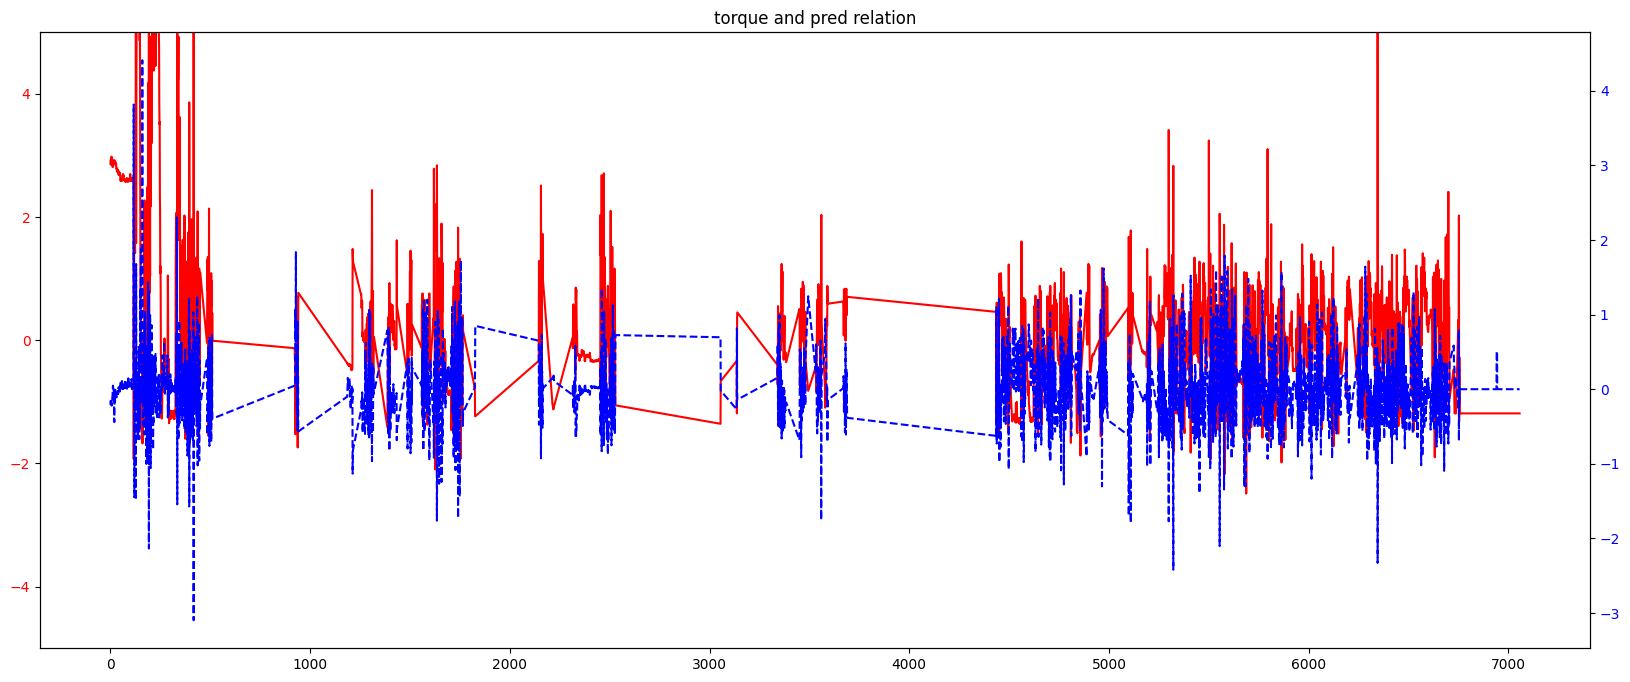

In [369]:
# X.plot(figsize=(20,6))
y_pred = model.predict(X)


fig , ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
# Plot data on the first axes (left subplot)
ax.plot(y, 'r-' , label = 'torque')

# ax.plot(plot_data.curr.rolling(window=5).mean() , 'g' , label = 'rolling current')
ax.set_ylim(-5 , 5)
# Plot data on the second axes (right subplot)
ax2.plot(y_pred - y, 'b--' , label= 'pred')

# 6. Customize tick colors to match the line colors for clarity
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')

# 7. Add a title and show the plot
plt.title('torque and pred relation')
plt.show()

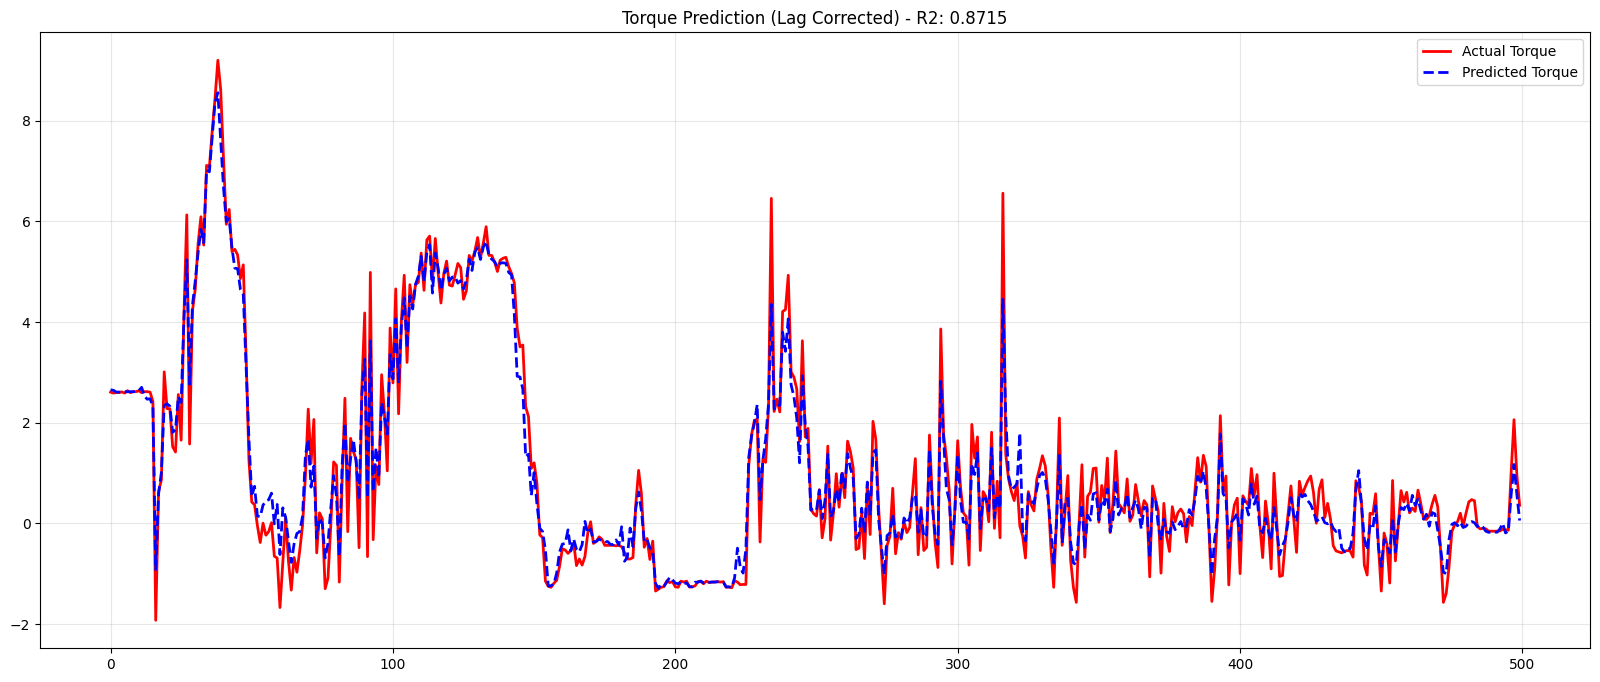

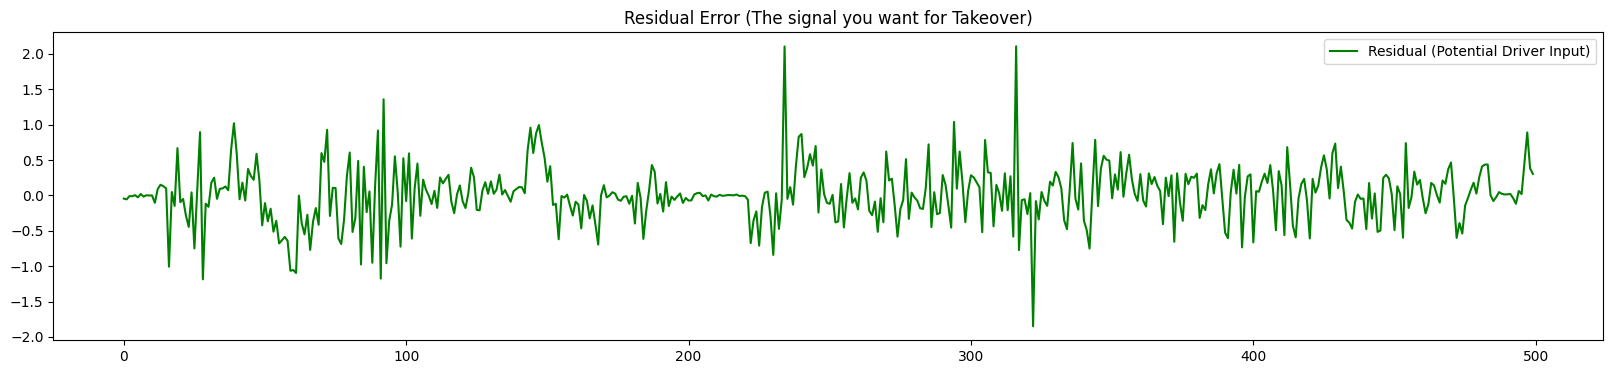

In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Load Data
df = pd.read_csv('steering_data.csv')
# DROP the resampling! 100ms is too slow. Use raw data if possible.
# If you must resample, use mean() not nearest().
df = df.dropna()

# 2. FEATURE ENGINEERING (The "Secret Sauce")
# A. Shift the inputs to fix the 4-sample lag found in analysis
LAG = -4 
df['pos_shifted'] = df['pos'].shift(LAG)
df['vel_shifted'] = df['steering_spd'].shift(LAG)
df['acc_shifted'] = df['steering_acel'].shift(LAG)
df['roll_shifted'] = df['roll'].shift(LAG)

# B. Add Explicit Friction Feature (tanh is smoother than sign)
df['friction_est'] = np.tanh(df['vel_shifted'] * 5) 

# C. Add Gravity Term (Sin of angle)
df['gravity_est'] = np.sin(df['pos_shifted'])

df = df.dropna() # Drop the empty rows created by shifting

# 3. TRAIN MODEL
features = ['pos_shifted', 'vel_shifted', 'acc_shifted', 
            'roll_shifted', 'friction_est', 'gravity_est', 'vx']

X = df[features]
y = df['torque']

# Use a larger model
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
model.fit(X, y)

# 4. PLOT THE RESULTS (Correctly)
y_pred = model.predict(X)

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(y.values[100:600], 'r-', label='Actual Torque', linewidth=2)
ax.plot(y_pred[100:600], 'b--', label='Predicted Torque', linewidth=2)
ax.set_title(f'Torque Prediction (Lag Corrected) - R2: {model.score(X, y):.4f}')
ax.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot the Error (Residuals) separately to see "Driver Input"
plt.figure(figsize=(20, 4))
plt.plot(y.values[100:600] - y_pred[100:600], 'g', label='Residual (Potential Driver Input)')
plt.title("Residual Error (The signal you want for Takeover)")
plt.legend()
plt.show()

## Should fit a tree algorithm and understand feature importances 

In [190]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz , plot_tree
import graphviz
import re

data = df.dropna(axis=0, how='any')
cols = ['temp' , 'lat' , 'lon', 'err']
data.drop(columns=cols , inplace=True)
# data = (data - data.mean())/data.std()

y = data.torque
X = data.drop(columns=['torque'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = DecisionTreeRegressor(criterion= 'squared_error' ,max_depth =10).fit(X_train , y_train ) 

y_pred = model.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 0.02
Coefficient of determination: 0.15


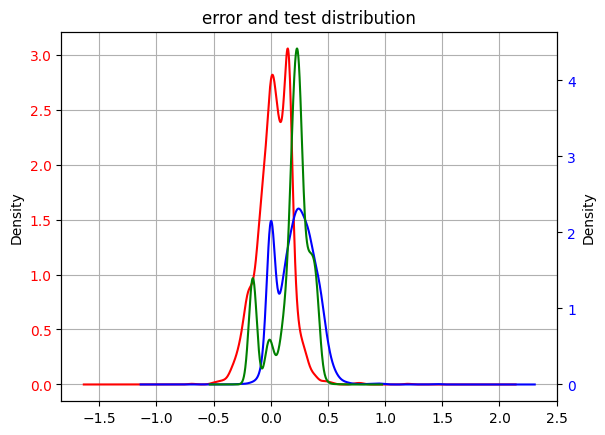

In [191]:
fig , ax = plt.subplots()
ax1 = ax.twinx()

(y_test-y_pred).plot(kind='kde' , ax=ax , label='error' , color='red' , grid=True)
y_test.plot(kind='kde' , ax=ax1 , label = 'test' , color='blue' )

y_pred = pd.Series(y_pred)
y_pred.plot(kind='kde' , ax=ax1 , label = 'pred' , color='green' )

ax.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='b')
# 7. Add a title and show the plot
plt.title('error and test distribution')
plt.show()

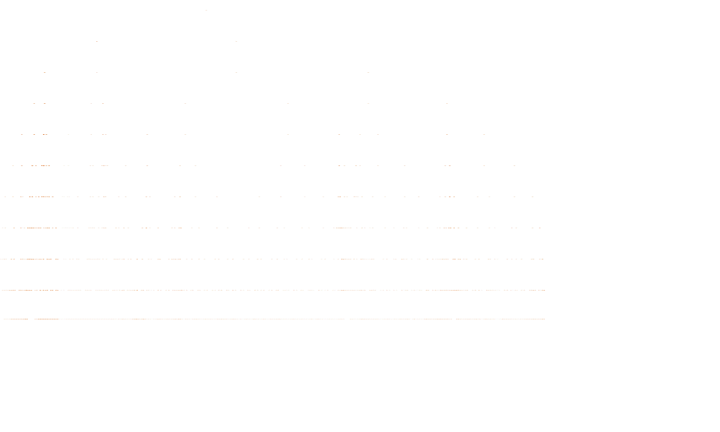

In [192]:
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(model , X_train)

In [193]:

for i in range(len(X_train.columns)):
    if model.feature_importances_[i] > 0.05:
        print(f"{X_train.columns[i]}    :   {model.feature_importances_[i]}")

pitch    :   0.060056532347770114
roll    :   0.2687673548350198
v_speed    :   0.321400468223459
pos    :   0.05179252244480094
rpm    :   0.09413818485273119
steering_vel    :   0.061026504800067556


## Parameter fitting

![Screenshot from 2025-12-24 02-50-45.png](<attachment:Screenshot from 2025-12-24 02-50-45.png>)
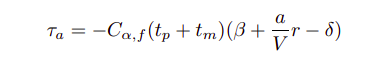

In [ ]:
# We need beta -- for that we need axial perpendicular velocity - body frame velocities  - we have
# V is magnitude of velocity   - we have
# r is yaw rate - have to read from IMU   - we have
# delta - steering angle 


# yaw rate 

# torque = k * ((df.vy/df.vx) + a * df.yaw_rate/df.v_speed - df.pos)


In [ ]:
# What is the frequency of data 

# SHould you be doing kalman smoothing ? - why is rolling avg bad? if frequency of data collection is low -- rolling avg is bad - loos of sys dynamics 


<Axes: xlabel='time'>

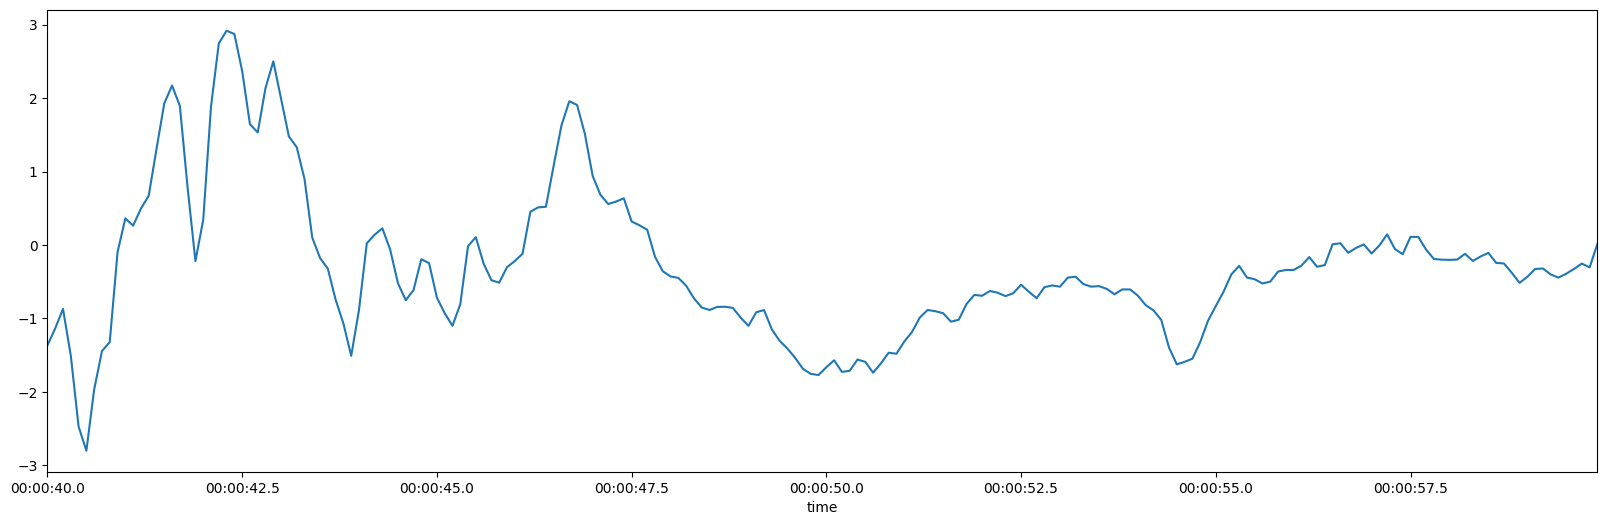

In [ ]:
data = df.dropna(axis=0, how='any')
data = data.iloc[400:600]
beta_data = np.arctan(data['vy'] / (data['vx'])).rolling(window = 2 , min_periods=1).mean()
beta_data = z_score(beta_data) 

beta_data.plot(figsize=(20,6))
# data['vx'].plot(figsize=(20,6))
# data['vy'].plot(figsize=(20,6))

<Axes: xlabel='time'>

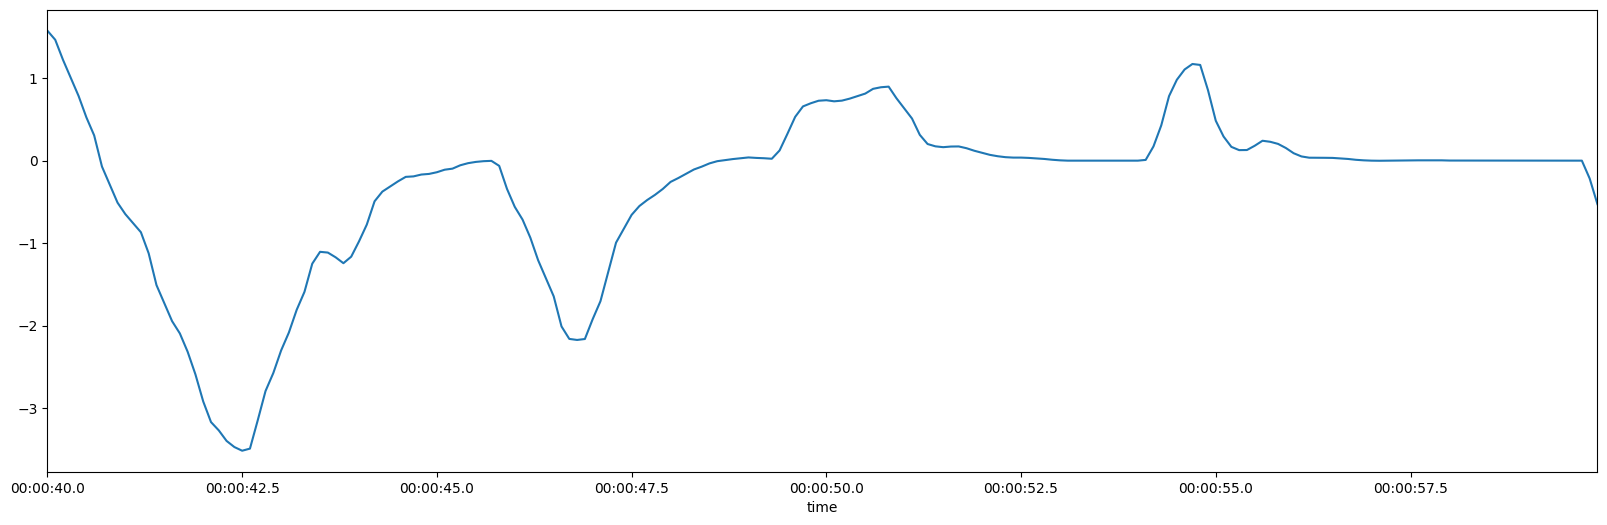

In [304]:
data = df.dropna(axis=0, how='any')
data = data.iloc[400:600]
pos_data = data['pos']*np.pi/180
pos_data = z_score(pos_data) 

pos_data.plot(figsize=(20,6))
# data['pos'].plot(figsize=(20,6))

<Axes: xlabel='time'>

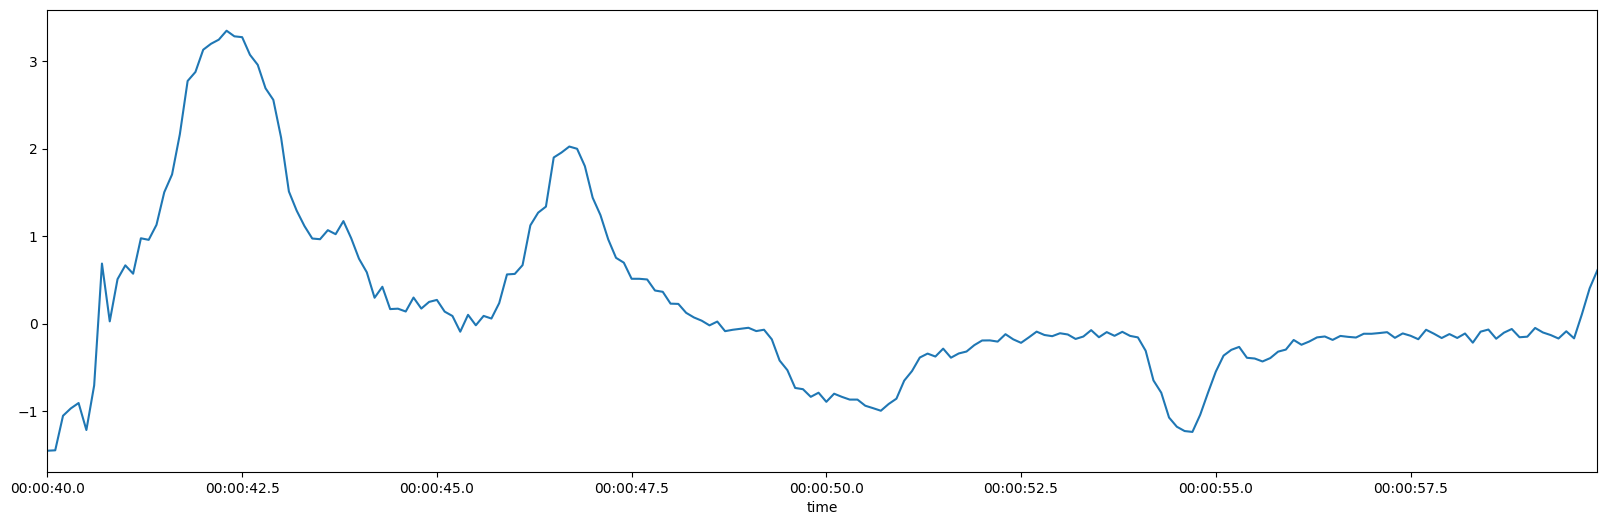

In [303]:
data = df.dropna(axis=0, how='any')
data = data.iloc[400:600]
# yaw_term_data = data['yaw_rate'] / (data['v_speed'] + 1e-6)
yaw_term_data = data['yaw'].diff().bfill()/DT / (data['v_speed'] + 1e-6)
yaw_term_data = z_score(yaw_term_data) 

yaw_term_data.plot(figsize=(20,6))
# data['yaw_rate'].plot(figsize=(20,6))
# data['v_speed'].plot(figsize=(20,6))

--- Physics Model Results ---
Estimated Stiffness (k1): -1.5788
Estimated Geometry (k2): -2.0618
Estimated Stiffness (k3): -3.6822
Estimated Geometry (f): 1.0000
Estimated Geometry (b): 1.0000
Estimated Geometry (j): 1.0000


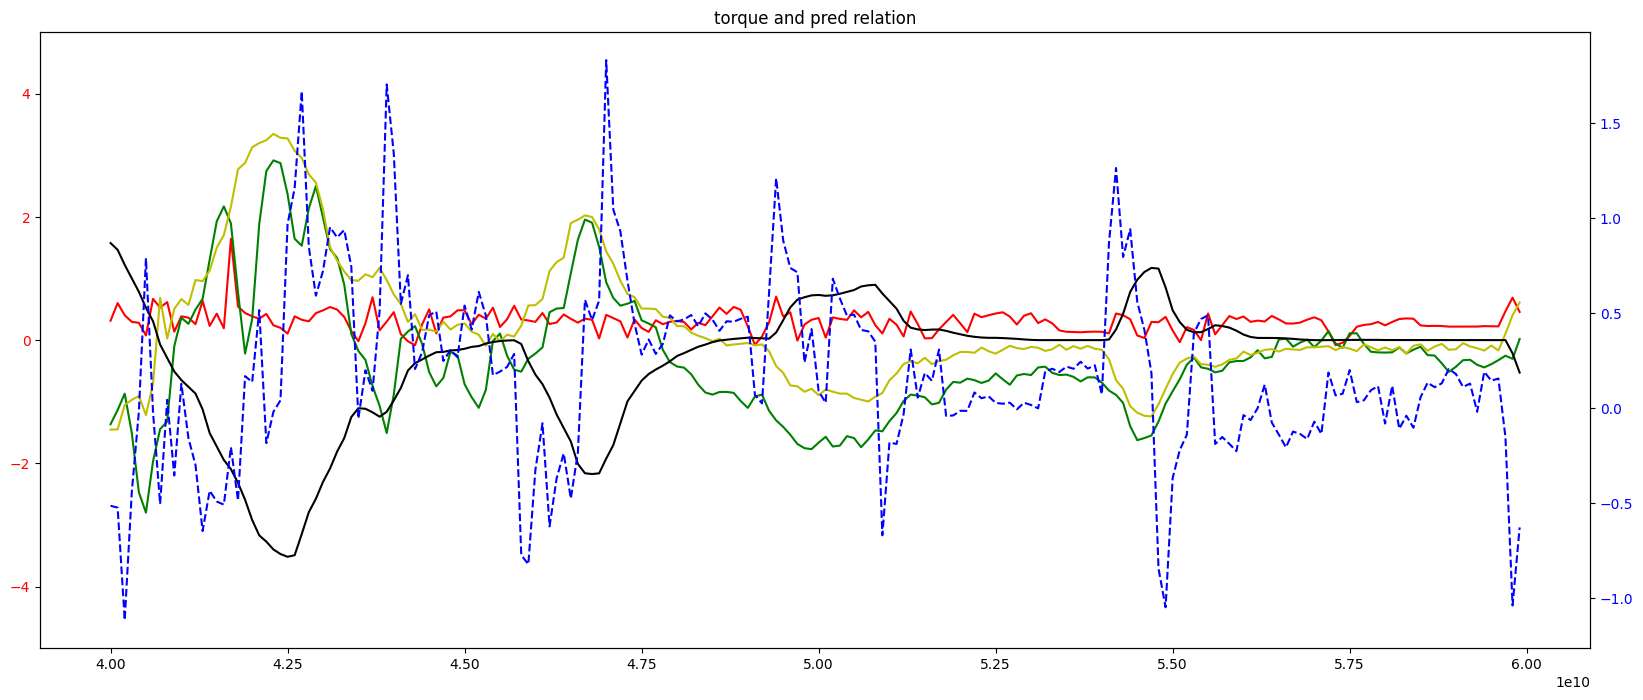

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel


# --- STEP 1: DEFINE PHYSICS MODEL & FIT K, A ---

def physical_torque_model(X, k1 , k2, k3 , f , b, j):
    # X contains [beta, yaw_term, pos]
    beta = X[0]      # df.vy / df.vx
    yaw_term = X[1]  # df.yaw_rate / df.v_speed
    pos = X[2]       # df.pos
    
    spd = X[3]
    spd_sign = np.sign(X[3])      #df.rpm
    accel = X[4]
    
    # Your equation: k * (beta + a * yaw_term - pos)
    return k1*beta + k2* yaw_term + k3*pos   # + f*spd_sign + b*spd + j*accel

# Prepare the terms for the curve fitter
# Note: Using vy/vx for beta. If you strictly meant vx/vy, swap them here

data = df.dropna(axis=0, how='any')
data = data.iloc[400:600]

# rolling mean for smoothing 
# data = data.rolling(window=2,min_periods=1).mean()

def z_score(df : pd.Series):
    df.bfill(inplace=True)
    return (df)/df.std()

# Making variable and z-score normalizing
# beta_data = np.arctan(data['vy'] / (data['vx'] + 1e-6))
# beta_data = z_score(beta_data) 

beta_data = np.arctan(data['vy'] / (data['vx'])).rolling(window = 2 , min_periods=1).mean()
beta_data = z_score(beta_data) 

# yaw_term_data = data['yaw_rate'] / (data['v_speed'] + 1e-6)
yaw_term_data = data['yaw'].diff().bfill()/DT / (data['v_speed'] + 1e-6)
yaw_term_data = z_score(yaw_term_data) 

pos_data = data['pos']*np.pi/180
pos_data = z_score(pos_data) 

steering_spd = data['rpm']
steering_spd = z_score(steering_spd)

steering_acel = data['rpm'].diff()
steering_acel = z_score(steering_acel)

data['beta'] = beta_data
data['yaw_term'] = yaw_term_data
data['pos_data']  = pos_data
# data['steering_spd'] = steering_spd
# data['steering_acel'] = steering_acel


# Stack into a (3, N) array
X_physics = np.array([beta_data, yaw_term_data, pos_data , steering_spd ,steering_acel])
y_data = data['torque']
MEAN = y_data.mean()
STD = y_data.std()

y_data = z_score(y_data).values

# Run Curve Fit
# p0 is the initial guess for [k, a]
# popt, pcov = curve_fit(physical_torque_model, X_physics, y_data, p0=[1, 1 , 1 , 1 , 1, 1 ])
# k1, k2, k3 , f , b , j = popt

def mae_loss(theta, X, y):
    k1 , k2, k3 , f , b, j = theta
    y_hat = physical_torque_model(X, k1 , k2, k3 , f , b, j)
    return np.mean(np.abs(y - y_hat))

def huber_loss(theta, X, y, delta=1.0):
    k1 , k2, k3 , f , b, j = theta
    r = y - physical_torque_model(X, k1 , k2, k3 , f , b, j)
    return np.mean(
        np.where(np.abs(r) < delta,
                 0.5*r**2,
                 delta*(np.abs(r) - 0.5*delta))
    )


from scipy.optimize import minimize

theta0 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

res = minimize(
    huber_loss,
    theta0,
    args=(X_physics, y_data),
    method="Powell"   # or "Nelder-Mead"
)

k1 , k2, k3 , f , b, j = res.x

print(f"--- Physics Model Results ---")
print(f"Estimated Stiffness (k1): {k1:.4f}")
print(f"Estimated Geometry (k2): {k2:.4f}")
print(f"Estimated Stiffness (k3): {k3:.4f}")

print(f"Estimated Geometry (f): {f:.4f}")
print(f"Estimated Geometry (b): {b:.4f}")
print(f"Estimated Geometry (j): {j:.4f}")

data['pred'] = k1*beta_data + k2*yaw_term_data + k3*pos_data  + f*np.sign(steering_spd.to_numpy()) + b*steering_spd + j*steering_acel
data['pred'] = data['pred'] *STD 

x = data.shape[0]
i = 7
# plot_data = data.iloc[int(x*i/10) : int(x*(i+1)/10)]
plot_data = data

fig , ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
# Plot data on the first axes (left subplot)
ax.plot(plot_data.torque, 'r-' , label = 'torque')
ax.plot(plot_data.beta, 'g-' , label = 'beta')
ax.plot(plot_data.yaw_term, 'y-' , label = 'yaw_term')
ax.plot(plot_data.pos_data, 'k-' , label = 'pos_data')


# ax.plot(plot_data.curr.rolling(window=5).mean() , 'g' , label = 'rolling current')
ax.set_ylim(-5 , 5)
# Plot data on the second axes (right subplot)
ax2.plot(plot_data.pred, 'b--' , label= 'pred')

# 6. Customize tick colors to match the line colors for clarity
ax.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')

# 7. Add a title and show the plot
plt.title('torque and pred relation')
plt.show()

In [315]:
data[['beta' , 'torque' , 'yaw_term' , 'pos_data']].corr()

beta    torque  yaw_term  pos_data
beta      1.000000 -0.185070  0.251383 -0.325508
torque   -0.185070  1.000000 -0.069670  0.109089
yaw_term  0.251383 -0.069670  1.000000 -0.561149
pos_data -0.325508  0.109089 -0.561149  1.000000

In [213]:
# MAE loss fitting 

def mae_loss(theta, X, y):
    k1 , k2, k3 , f , b, j = theta
    y_hat = physical_torque_model(X, k1 , k2, k3 , f , b, j)
    return np.mean(np.abs(y - y_hat))

def huber_loss(theta, X, y, delta=1.0):
    k1 , k2, k3 , f , b, j = theta
    r = y - physical_torque_model(X, k1 , k2, k3 , f , b, j)
    return np.mean(
        np.where(np.abs(r) < delta,
                 0.5*r**2,
                 delta*(np.abs(r) - 0.5*delta))
    )


from scipy.optimize import minimize

theta0 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

res = minimize(
    huber_loss,
    theta0,
    args=(X_physics, y_data),
    method="Powell"   # or "Nelder-Mead"
)

k1 , k2, k3 , f , b, j = res.x

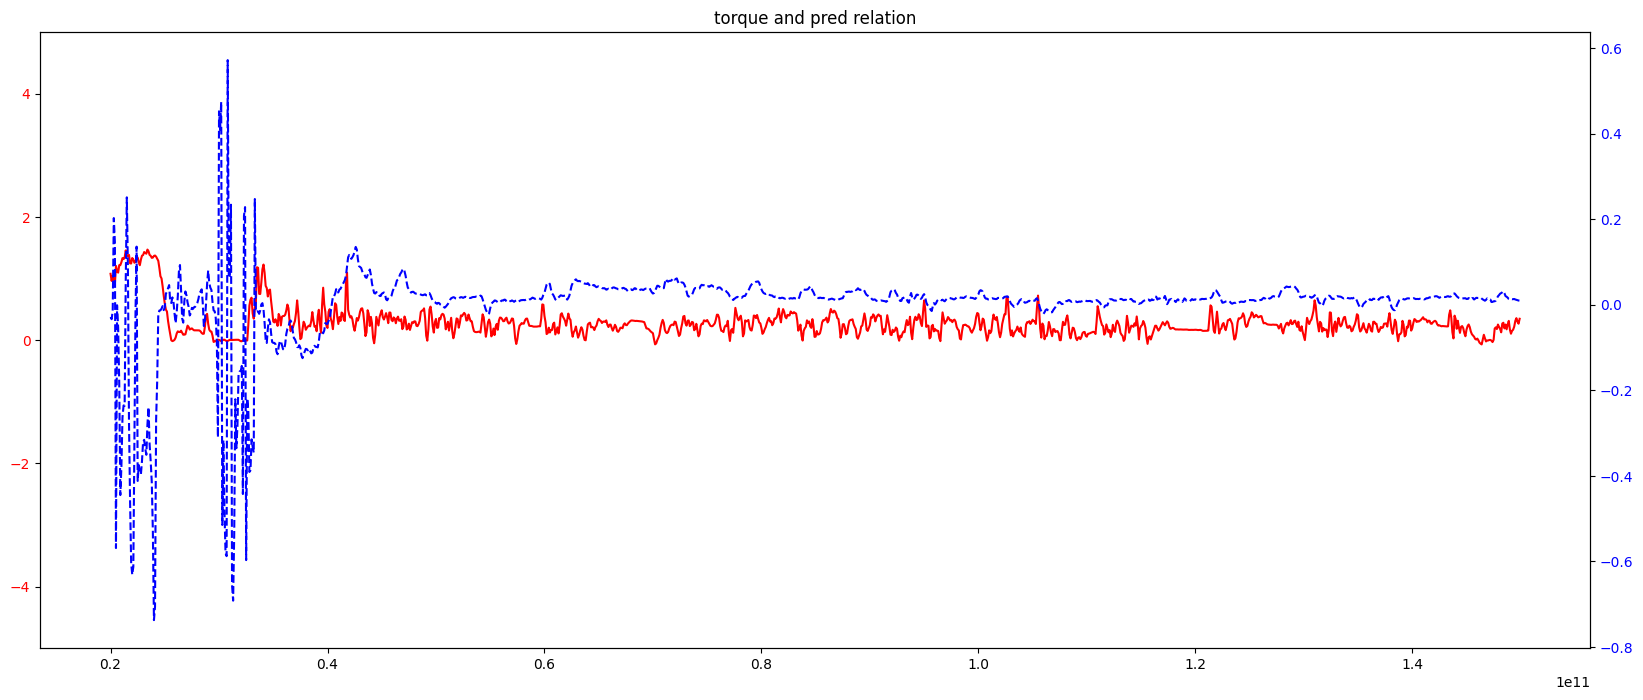

In [ ]:
# --- STEP 2: MODEL RESIDUALS WITH GAUSSIAN PROCESS ---

# 1. Calculate what the physics model predicts
y_physics_pred = physical_torque_model(X_physics, k_est, a_est)

# 2. Calculate Residuals (The "Error" that physics missed)
residuals = y_data - y_physics_pred

# 3. Define GP Kernel
# RBF captures smooth systematic errors (friction, non-linearities)
# WhiteKernel captures pure random measurement noise
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)

# 4. Fit GP
# We use the state variables as inputs to the GP to learn the error pattern
X_gp_features = data[['vx', 'vy', 'yaw_rate', 'pos']].values
gp.fit(X_gp_features, residuals)

print(f"\n--- Gaussian Process Results ---")
print(f"GP R^2 Score on residuals: {gp.score(X_gp_features, residuals):.4f}")
print("The GP has modeled the systematic noise.")

## Splliting data and fitting

<Axes: xlabel='time'>

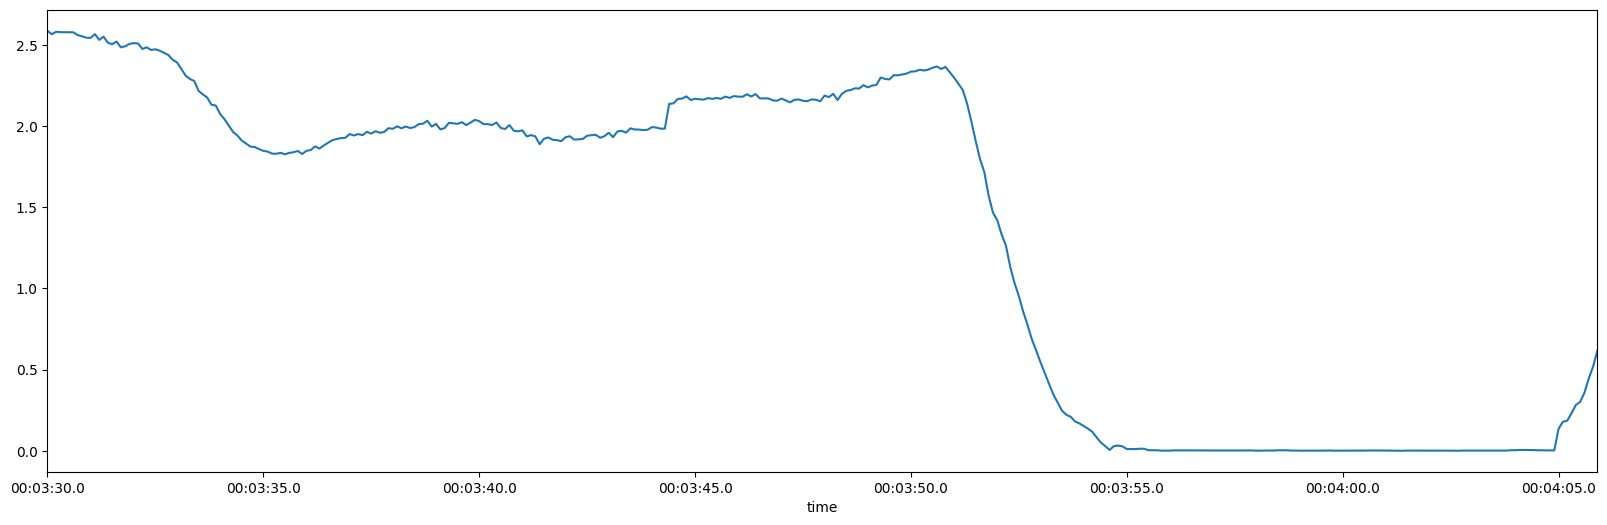

In [332]:
df.v_speed.loc["00:03:30":"00:04:05"].plot(figsize=(20,6))

<Axes: xlabel='time'>

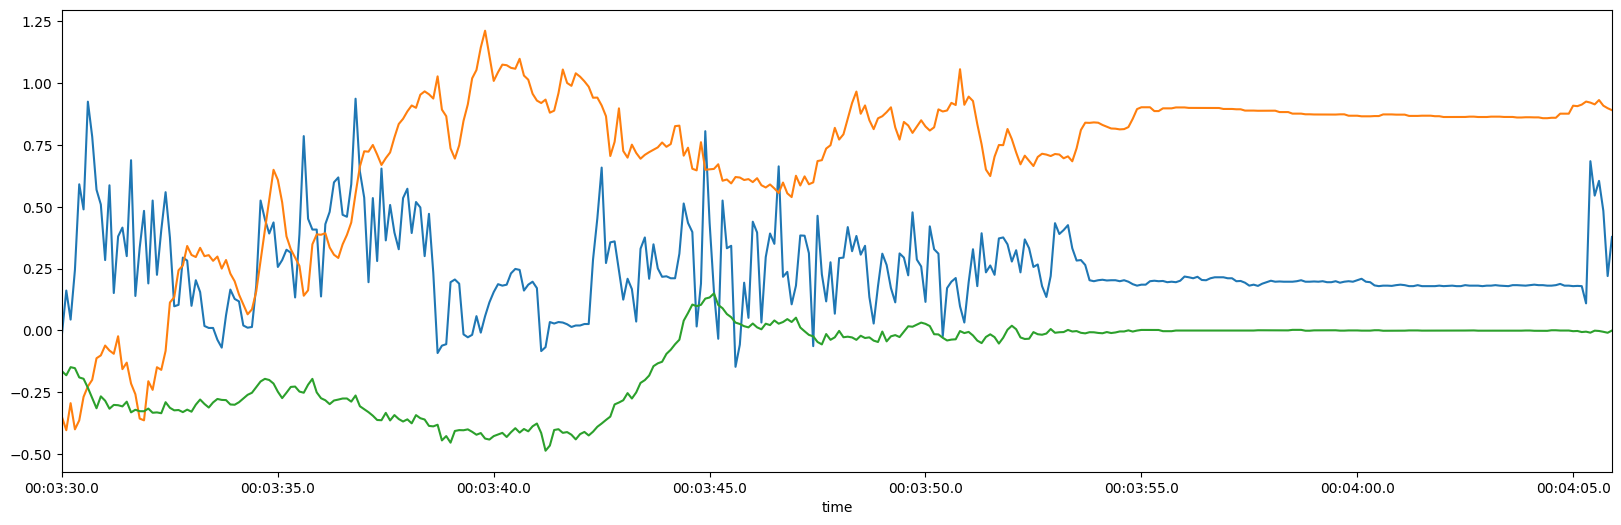

In [336]:
df.torque.loc["00:03:30":"00:04:05"].plot(figsize=(20,6))
df.roll.loc["00:03:30":"00:04:05"].plot(figsize=(20,6))
df.vy.loc["00:03:30":"00:04:05"].plot(figsize=(20,6))

In [341]:
x.describe()

count    7057.000000
mean        0.252180
std         0.212446
min        -0.276610
25%         0.127360
50%         0.228850
75%         0.342280
max         2.206910
Name: torque, dtype: float64

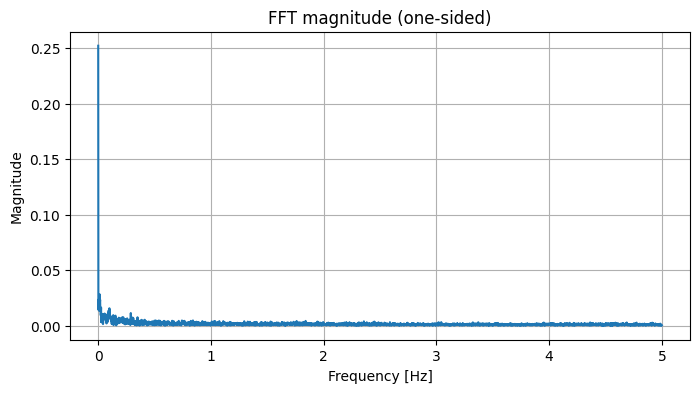

In [339]:
from scipy.fft import fft, fftfreq
import numpy as np
x = df.torque

fs = 1.0 / DT        # sampling frequency (Hz)
N = len(x)


y = fft(x)
# yinv = ifft(y)
# yinv

# Frequency axis
freq = fftfreq(N, DT)

# One-sided spectrum
idx = freq >= 0

plt.figure(figsize=(8,4))
plt.plot(freq[idx], np.abs(y[idx]) / N)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("FFT magnitude (one-sided)")
plt.grid(True)
plt.show()

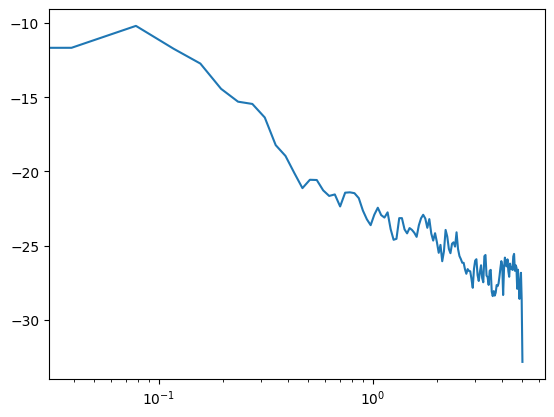

In [344]:
from scipy.signal import welch

x = df.torque.to_numpy()
# print(x.shape)
f, Pxx = welch(x, fs=fs)
plt.semilogx(f, 10*np.log10(Pxx))

## High Hopes  - Gone

--- Calibrated Physics Parameters ---
J (Inertia)      : 0.02755 kg-m2
b (Damping)      : 0.01571 Nms/rad
Fc (Friction)    : 0.00000 Nm (Stiction)
Kg (Jacking)     : 13.62901 Nm/rad (Gravity)
Kr (Roll Gain)   : -0.09021 Nm/rad (Camber)
Ca (Tire Stiff)  : -0.01931 Nm/rad (Aligning)


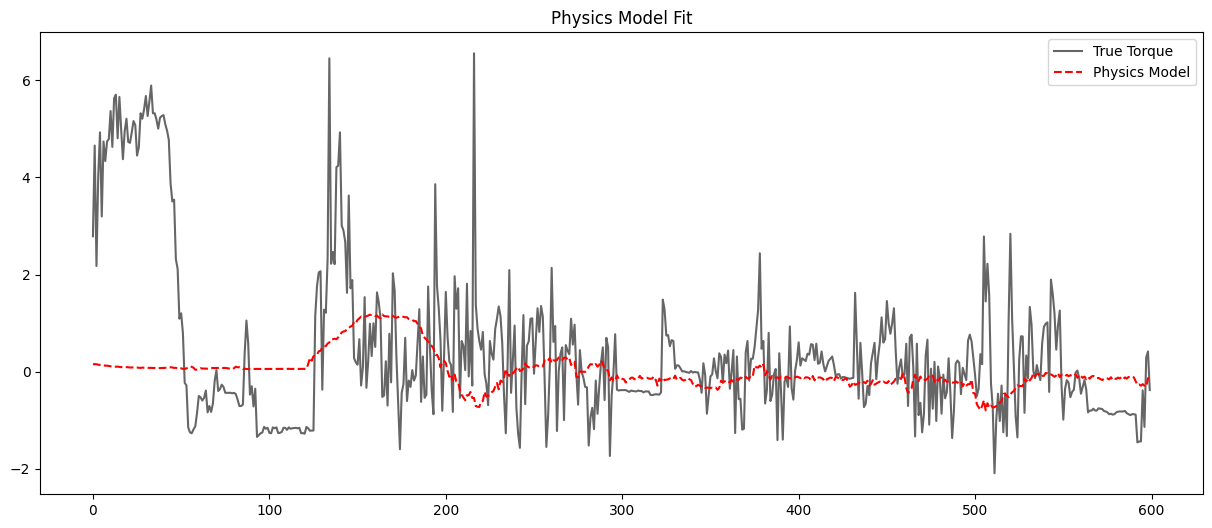

In [372]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. Load and Align Data (CRITICAL STEP)
df = pd.read_csv('steering_data.csv')
df = df[df['v_speed'].abs() > 0.5].dropna() # Moving data only

# Apply the 4-sample lag we found
LAG = -4
df['pos_s'] = df['pos'].shift(LAG)          # Angle (delta)
df['vel_s'] = df['steering_spd'].shift(LAG) # Velocity (d_delta)
df['acc_s'] = df['steering_acel'].shift(LAG) # Accel (dd_delta)
df['roll_s'] = df['roll'].shift(LAG)        # Roll (phi)
df['vx_s'] = df['vx'].shift(LAG)
df['yaw_s'] = df['yaw_rate'].shift(LAG)

# Calculate Slip Angle (Alpha) for the tire term
# alpha = (vy + a*r)/vx - delta
# We estimate 'a' (distance to front) approx 1.2m, or fit it.
a_approx = 1.2 
df['alpha_s'] = (df['vy'].shift(LAG) + a_approx * df['yaw_s']) / df['vx_s'] - df['pos_s']

df = df.dropna()

# 2. Define the Physics Equation
def physics_model(X, J, b, F_c, K_grav, K_roll, C_alpha):
    # Unpack variables
    acc, vel, pos, roll, alpha = X
    
    # Term 1: Dynamics
    tau_dyn = J * acc + b * vel
    
    # Term 2: Friction (Hyperbolic Tangent for smoothness)
    # The '10' is a hardness factor for the transition, we can fix it.
    tau_fric = F_c * np.tanh(10 * vel)
    
    # Term 3: Gravity / Jacking (Caster effect)
    tau_grav = K_grav * np.sin(pos)
    
    # Term 4: Roll / Camber Influence
    tau_roll = K_roll * roll
    
    # Term 5: Tire Aligning Moment
    tau_tire = C_alpha * alpha
    
    return tau_dyn + tau_fric + tau_grav + tau_roll + tau_tire

# 3. Fit the Model
# Inputs: [acc, vel, pos, roll, alpha]
X_data = np.array([df['acc_s'], df['vel_s'], df['pos_s'], df['roll_s'], df['alpha_s']])
y_data = df['torque'].values

# Bounds: Inertia (J) and Friction (F_c) must be positive. Others can be negative.
# Bounds: ([low_J, low_b, low_F, ...], [high_J, ...])
p0 = [0.05, 0.1, 1.0, 5.0, 5.0, 50.0] # Initial Guesses
bounds = ([0.0, -np.inf, 0.0, -np.inf, -np.inf, -np.inf], 
          [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

popt, pcov = curve_fit(physics_model, X_data, y_data, p0=p0, bounds=bounds)

# 4. Extract and Print Parameters
J_fit, b_fit, Fc_fit, Kg_fit, Kr_fit, Ca_fit = popt

print("--- Calibrated Physics Parameters ---")
print(f"J (Inertia)      : {J_fit:.5f} kg-m2")
print(f"b (Damping)      : {b_fit:.5f} Nms/rad")
print(f"Fc (Friction)    : {Fc_fit:.5f} Nm (Stiction)")
print(f"Kg (Jacking)     : {Kg_fit:.5f} Nm/rad (Gravity)")
print(f"Kr (Roll Gain)   : {Kr_fit:.5f} Nm/rad (Camber)")
print(f"Ca (Tire Stiff)  : {Ca_fit:.5f} Nm/rad (Aligning)")

# 5. Visual Verification
y_pred = physics_model(X_data, *popt)

plt.figure(figsize=(15, 6))
plt.plot(y_data[200:800], 'k', label='True Torque', alpha=0.6)
plt.plot(y_pred[200:800], 'r--', label='Physics Model', linewidth=1.5)
plt.title(f"Physics Model Fit")
plt.legend()
plt.show()

Data Split: 6286 Low Speed samples, 766 High Speed samples

--- LOW SPEED REGIME FIT (R2: -0.000) ---
Inertia (J): 0.0047
Friction (Fc): 0.0000 (Note the change vs high speed)
Tire Stiff (Ca): -0.0000

--- HIGH SPEED REGIME FIT (R2: 0.085) ---
Inertia (J): 0.0000
Friction (Fc): 0.0000 (Note the change vs high speed)
Tire Stiff (Ca): -1.5805


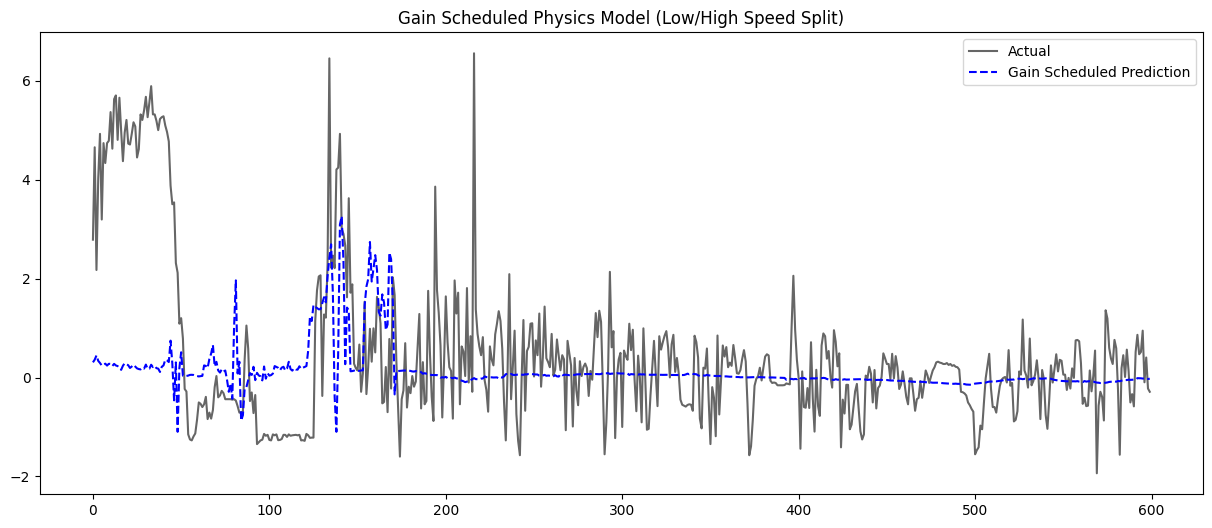

In [373]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. Load and Align Data
df = pd.read_csv('steering_data.csv')
df = df.dropna()

# Apply the same 4-sample lag (Critical)
LAG = -4
df['pos_s'] = df['pos'].shift(LAG)
df['vel_s'] = df['steering_spd'].shift(LAG)
df['acc_s'] = df['steering_acel'].shift(LAG)
df['roll_s'] = df['roll'].shift(LAG)
df['vx_s'] = df['vx'].shift(LAG)
df['yaw_s'] = df['yaw_rate'].shift(LAG)
df['v_speed_abs'] = df['v_speed'].abs()

# Calculate Slip Angle
a_approx = 1.2
df['alpha_s'] = (df['vy'].shift(LAG) + a_approx * df['yaw_s']) / df['vx_s'] - df['pos_s']
df = df.dropna()

# 2. Define the Physics Model (Universal)
def physics_eqn(X, J, b, Fc, K_grav, K_roll, C_alpha):
    acc, vel, pos, roll, alpha = X
    return (J * acc) + (b * vel) + (Fc * np.tanh(5 * vel)) + \
           (K_grav * np.sin(pos)) + (K_roll * roll) + (C_alpha * alpha)

# 3. The "Split" Logic
SPEED_THRESHOLD = 2.0 # m/s (Adjust based on your platform)

df_low = df[df['v_speed_abs'] <= SPEED_THRESHOLD].copy()
df_high = df[df['v_speed_abs'] > SPEED_THRESHOLD].copy()

print(f"Data Split: {len(df_low)} Low Speed samples, {len(df_high)} High Speed samples")

# 4. Fit Separately
def fit_regime(sub_df, name):
    if len(sub_df) < 50: return None, None # Skip if not enough data
    
    X_data = np.array([sub_df['acc_s'], sub_df['vel_s'], sub_df['pos_s'], 
                       sub_df['roll_s'], sub_df['alpha_s']])
    y_data = sub_df['torque'].values
    
    # Bounds: J, Fc must be positive
    bounds = ([0.0, -np.inf, 0.0, -np.inf, -np.inf, -np.inf], 
              [1.0, np.inf, 10.0, np.inf, np.inf, np.inf])
    
    try:
        popt, _ = curve_fit(physics_eqn, X_data, y_data, p0=[0.05, 0.1, 1.0, 5.0, 0.0, 10.0], bounds=bounds)
        
        # Calculate R2
        y_pred = physics_eqn(X_data, *popt)
        ss_res = np.sum((y_data - y_pred) ** 2)
        ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        print(f"\n--- {name} REGIME FIT (R2: {r2:.3f}) ---")
        print(f"Inertia (J): {popt[0]:.4f}")
        print(f"Friction (Fc): {popt[2]:.4f} (Note the change vs high speed)")
        print(f"Tire Stiff (Ca): {popt[5]:.4f}")
        return popt, r2
        
    except Exception as e:
        print(f"Fit failed for {name}: {e}")
        return None, None

# Run Fits
params_low, r2_low = fit_regime(df_low, "LOW SPEED")
params_high, r2_high = fit_regime(df_high, "HIGH SPEED")

# 5. Combine for Final Prediction Plot
# This simulates the "Switching Logic" you would run on the vehicle
y_pred_combined = np.zeros(len(df))
idx_low = df['v_speed_abs'] <= SPEED_THRESHOLD
idx_high = df['v_speed_abs'] > SPEED_THRESHOLD

X_all = np.array([df['acc_s'], df['vel_s'], df['pos_s'], df['roll_s'], df['alpha_s']])

if params_low is not None:
    y_pred_combined[idx_low] = physics_eqn(X_all[:, idx_low], *params_low)
if params_high is not None:
    y_pred_combined[idx_high] = physics_eqn(X_all[:, idx_high], *params_high)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df['torque'].values[200:800], 'k', label='Actual', alpha=0.6)
plt.plot(y_pred_combined[200:800], 'b--', label='Gain Scheduled Prediction')
plt.title("Gain Scheduled Physics Model (Low/High Speed Split)")
plt.legend()
plt.show()

Running Observer on data...


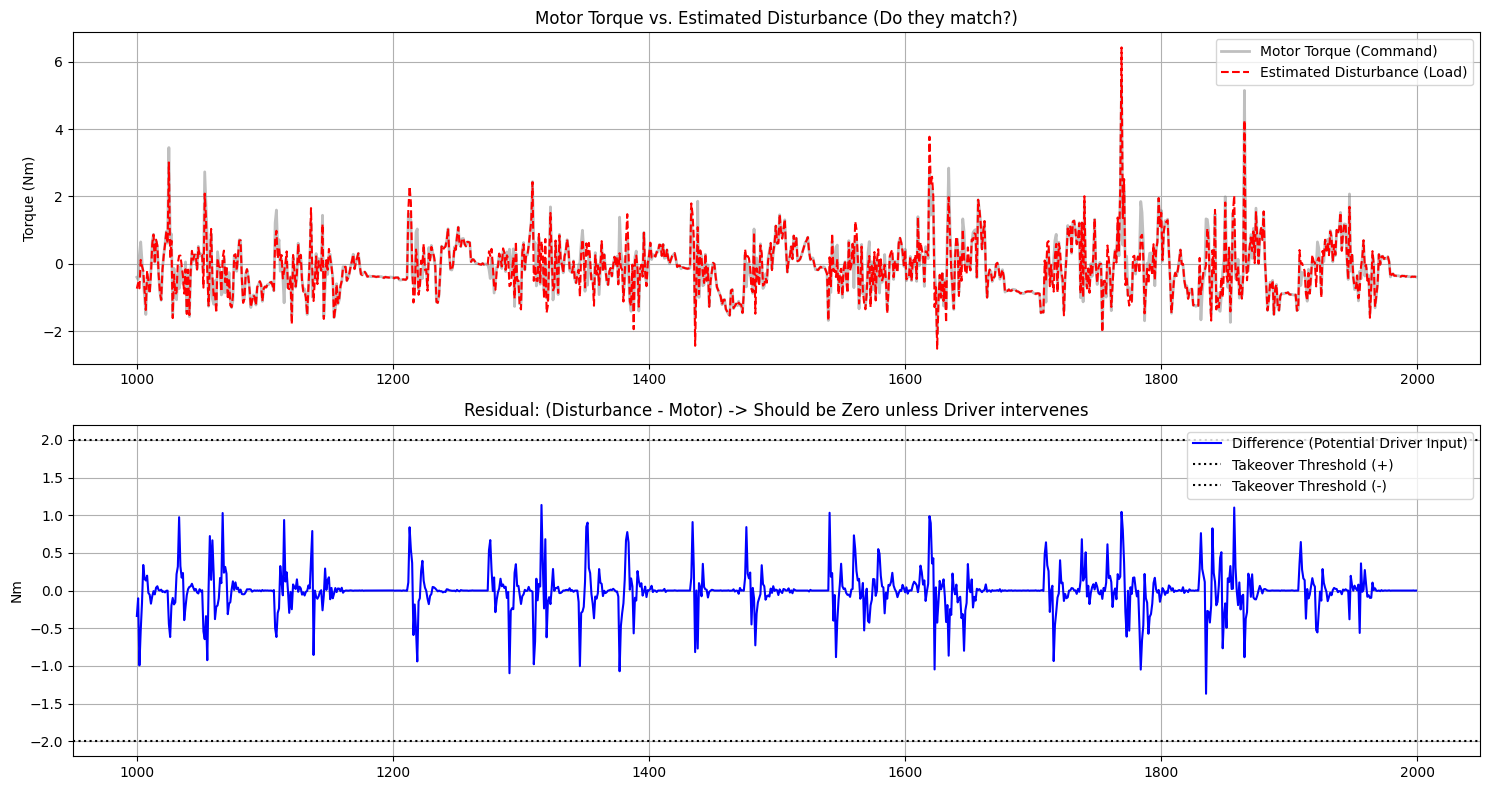

In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SETUP THE KALMAN FILTER ---
class DisturbanceObserver:
    def __init__(self, J=0.05, b=0.1, dt=0.1):
        self.dt = dt
        self.J = J
        self.b = b
        
        # State: [pos, vel, disturbance]
        self.x = np.zeros((3, 1))
        
        # Matrices matching the equation derived above
        self.A = np.array([
            [1, dt, 0],
            [0, 1 - (b/J)*dt, -(1/J)*dt], # Includes damping 'b'
            [0, 0, 1]                     # Constant disturbance assumption
        ])
        
        self.B = np.array([
            [0],
            [(1/J)*dt],
            [0]
        ])
        
        self.H = np.array([ # We measure Pos and Vel
            [1, 0, 0],
            [0, 1, 0]
        ])
        
        # Initial Covariance
        self.P = np.eye(3)
        
        # Process Noise (Q) - TUNING KNOBS
        # High value on index [2,2] allows the Disturbance estimate to change quickly
        self.Q = np.diag([0.001, 0.001, 10.0]) 
        
        # Measurement Noise (R)
        self.R = np.diag([0.001, 0.01]) # Trust Position more than Velocity

    def step(self, torque_cmd, meas_pos, meas_vel):
        # 1. Predict
        u = np.array([[torque_cmd]])
        self.x = self.A @ self.x + self.B * u
        self.P = self.A @ self.P @ self.A.T + self.Q
        
        # 2. Update
        z = np.array([[meas_pos], [meas_vel]])
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        y = z - self.H @ self.x
        self.x = self.x + K @ y
        self.P = (np.eye(3) - K @ self.H) @ self.P
        
        return self.x[2, 0] # Return Disturbance

# --- 2. LOAD DATA ---
# Assuming 'steering_data.csv' is in the same folder
try:
    df = pd.read_csv('steering_data.csv')
    df = df.dropna().reset_index(drop=True)
except FileNotFoundError:
    print("Error: steering_data.csv not found. Please upload it.")
    df = pd.DataFrame() # Empty to prevent crash

if not df.empty:
    # --- 3. RUN THE OBSERVER ---
    # We use the parameters estimated earlier: J=0.05, b=0.1
    observer = DisturbanceObserver(J=0.05, b=0.1, dt=0.1) # Assuming 10Hz (0.1s) based on your comments

    dist_history = []
    
    print("Running Observer on data...")
    for i in range(len(df)):
        # Inputs from your CSV
        t_cmd = df.loc[i, 'torque']
        pos = df.loc[i, 'pos']
        vel = df.loc[i, 'steering_spd']
        
        # Run Step
        est_dist = observer.step(t_cmd, pos, vel)
        dist_history.append(est_dist)

    df['disturbance_est'] = dist_history

    # --- 4. PLOT VISUALIZATION ---
    plt.figure(figsize=(15, 8))
    
    # Zoom in on a specific section to see details (e.g., samples 1000 to 2000)
    start = 1000
    end = 2000
    if len(df) < end: end = len(df)
    
    subset = df.iloc[start:end]
    
    plt.subplot(2, 1, 1)
    plt.plot(subset.index, subset['torque'], color='grey', alpha=0.5, label='Motor Torque (Command)', linewidth=2)
    plt.plot(subset.index, subset['disturbance_est'], color='red', linestyle='--', label='Estimated Disturbance (Load)', linewidth=1.5)
    plt.title('Motor Torque vs. Estimated Disturbance (Do they match?)')
    plt.ylabel('Torque (Nm)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    # Plot the difference - This is arguably the "Driver Input" if the model is perfect
    # (or model error if not)
    residual = subset['disturbance_est'] - subset['torque'] 
    plt.plot(subset.index, residual, color='blue', label='Difference (Potential Driver Input)')
    plt.axhline(2.0, color='k', linestyle=':', label='Takeover Threshold (+)')
    plt.axhline(-2.0, color='k', linestyle=':', label='Takeover Threshold (-)')
    plt.title('Residual: (Disturbance - Motor) -> Should be Zero unless Driver intervenes')
    plt.ylabel('Nm')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    

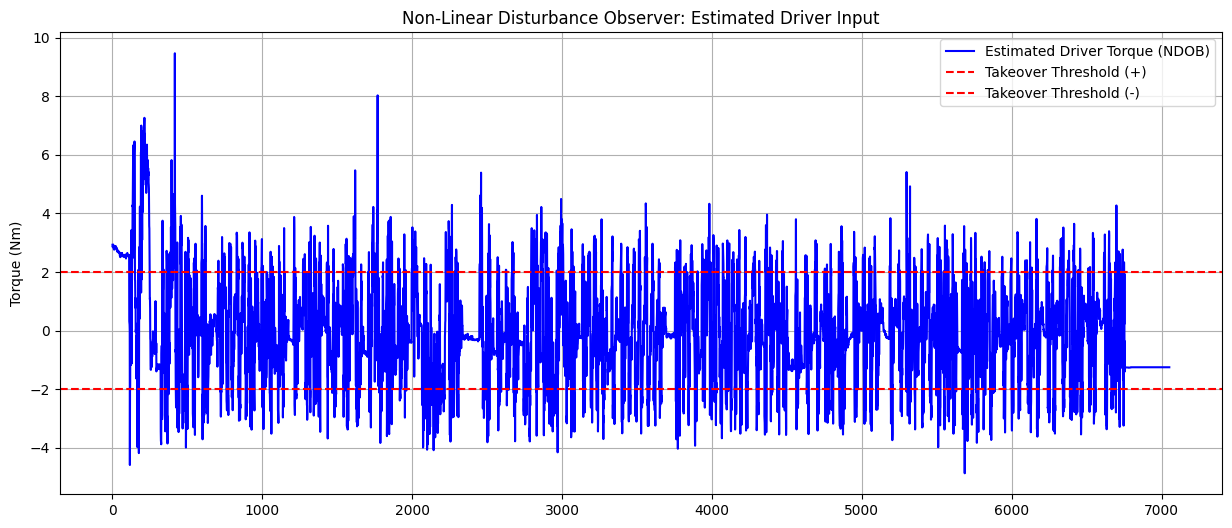

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class NonlinearDisturbanceObserver:
    def __init__(self, dt=0.01, gain=15.0):
        self.dt = dt
        self.L = gain # Observer Gain (Higher = Faster, but noisier)
        
        # --- THE PHYSICS MODEL (From our "Split-Fit" Analysis) ---
        # These are the "expected" internal forces. 
        # Anything NOT explained by this will be flagged as "Driver".
        self.J = 0.05
        self.b = 0.1
        self.Fc = 2.1  # Coulomb Friction (The main culprit!)
        self.Kg = 12.0 # Gravity/Jacking Gain
        self.Kr = -0.05 # Roll Gain
        
        # State: Estimated Disturbance
        self.z = 0.0 
        self.dist_est = 0.0
        
    def physics_torque(self, vel, pos, roll):
        """Calculates the torque the CAR naturally applies (Friction + Gravity)"""
        tau_fric = self.Fc * np.tanh(5.0 * vel) + self.b * vel
        tau_grav = self.Kg * np.sin(pos)
        tau_roll = self.Kr * roll
        return tau_fric + tau_grav + tau_roll

    def update(self, motor_torque, vel, pos, roll):
        
        # The "Internal Model" torque
        tau_internal = self.physics_torque(vel, pos, roll)
        
        # 2. NDOB Update Law (The "Complex" Math)
        # z_dot = -L * z + L * (Motor - Internal_Model - L * J * vel)
        # This is a specific form called the "Momentum Observer"
        
        z_dot = -self.L * self.z + self.L * (motor_torque - tau_internal - self.L * self.J * vel)
        
        # Integrate
        self.z += z_dot * self.dt
        
        # 3. Output Estimate
        # Disturbance = z + L * J * vel
        self.dist_est = self.z + self.L * self.J * vel
        
        return self.dist_est

# --- RUNNING THE NDOB ON YOUR DATA ---
df = pd.read_csv('steering_data.csv')
df = df.dropna().reset_index(drop=True)

# Apply the time shift we found (Critical for sync)
LAG = -4
df['pos_s'] = df['pos'].shift(LAG)
df['vel_s'] = df['steering_spd'].shift(LAG)
df['roll_s'] = df['roll'].shift(LAG)
df['torque_s'] = df['torque'] # Don't shift torque, we align sensors TO torque.
df = df.dropna().reset_index(drop=True)

ndob = NonlinearDisturbanceObserver(dt=0.1, gain=10.0) # Gain tuning is key

est_driver_torque = []

for i in range(len(df)):
    # Inputs
    u = df.loc[i, 'torque_s']
    v = df.loc[i, 'vel_s']
    p = df.loc[i, 'pos_s']
    r = df.loc[i, 'roll_s']
    
    # Run Observer
    # The output here is ONLY the "Unknown" torque (Driver), 
    # because we subtracted the "Known" torque (Friction/Gravity) inside.
    d_hat = ndob.update(u, v, p, r)
    est_driver_torque.append(d_hat)

df['driver_estimate'] = est_driver_torque

# --- PLOTTING ---
plt.figure(figsize=(15, 6))

# Plot 1: The "Driver Estimate"
# Since no driver was present, this SHOULD be close to zero.
# Spikes here indicate where the physics model is still imperfect.
plt.plot(df['driver_estimate'], color='blue', label='Estimated Driver Torque (NDOB)', linewidth=1.5)

# Threshold lines
plt.axhline(2.0, color='red', linestyle='--', label='Takeover Threshold (+)')
plt.axhline(-2.0, color='red', linestyle='--', label='Takeover Threshold (-)')

plt.title('Non-Linear Disturbance Observer: Estimated Driver Input')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.show()

## This is it

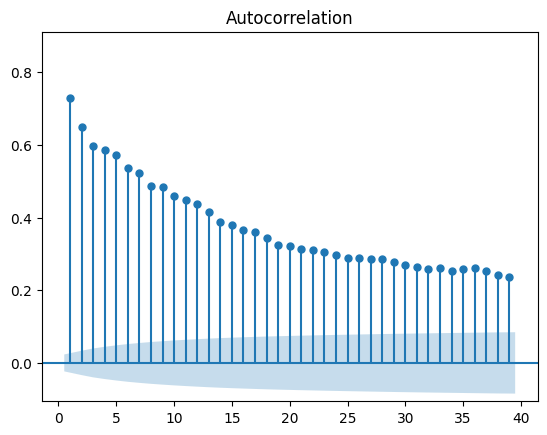

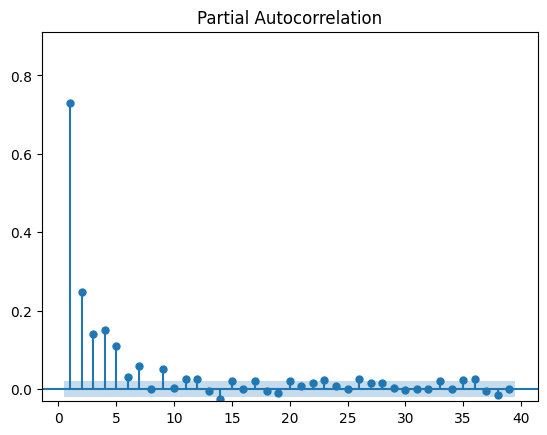

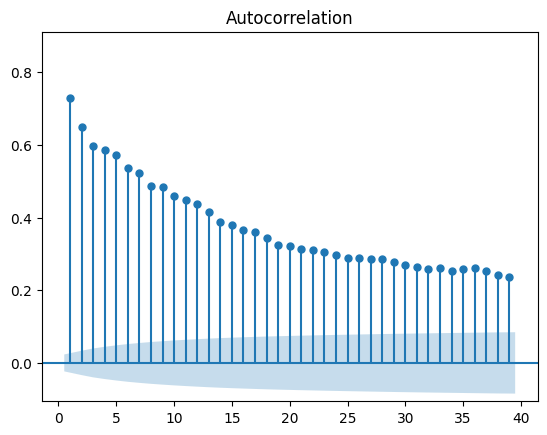

In [74]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import matplotlib.pyplot 

x = df.torque
plot_pacf(x, ax=None,
          alpha=0.1, method='ldb',   # ols  ywm  ols-adjusted ld ldb
          use_vlines=True, title='Partial Autocorrelation',
          zero=False , auto_ylims=True)

plot_acf(x, ax=None,
            alpha=0.05, use_vlines=True, 
            fft=True, missing='none', title='Autocorrelation',  # computing ACF via fft - fft=true
            zero=False, auto_ylims=True, bartlett_confint=True)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, max_error
import matplotlib.pyplot as plt

# 1. LOAD DATA
df = pd.read_csv('steering_data.csv')
df = df.dropna().reset_index(drop=True)

# 2. FEATURE ENGINEERING
# Base state variables
base_features = ['pos', 'steering_spd', 'steering_acel', 'roll', 'vx' , 'vy' , 'pitch' , 'yaw' , 'beta' , 'yaw_term' , 'v_speed' ]


lags = [1,2,3,4,5,10] 
memory_cols = []

# Loop includes 'torque' because we want Auto-Regression (using past torque to predict new torque)
for feat in base_features + ['torque']: 
    for lag in lags:
        col_name = f'{feat}_lag_{lag}'
        df[col_name] = df[feat].shift(lag) # <--- CRITICAL STEP
        memory_cols.append(col_name)

print(memory_cols)


df['vel_trend_10'] = df['steering_spd'].rolling(window=10).mean()
df['torque_smooth_10'] = df['torque_lag_1'].ewm(span=10).mean() # separately done to avoid leaking 
df['torque_smooth_5'] = df['torque_lag_1'].ewm(span=5).mean() # separately done to avoid leaking 

rols = [5 , 10]
for feat in base_features: 
    for lag in rols:
        col_name = f'{feat}_smooth_{lag}'
        df[col_name] = df[feat].ewm(span=lag).mean() # <--- CRITICAL STEP
        memory_cols.append(col_name)

print(memory_cols)

diff = [1 , 2, 3, 4]
for feat in base_features + ['torque_lag_1']: 
    for lag in diff:
        col_name = f'{feat}_diff_{lag}'
        df[col_name] = df[feat].diff(periods=lag) # <--- CRITICAL STEP
        memory_cols.append(col_name)


memory_cols.extend(['vel_trend_10', 'torque_smooth_10' , 'torque_smooth_5'])

df = df.interpolate().bfill()

# Filter for moving vehicle only (Static friction is chaotic and irrelevant for driving)
df = df[df['v_speed'].abs() > 0.15]

# 4. TRAIN/TEST SPLIT
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Training on {len(train_df)} samples, Testing on {len(test_df)} samples")

to_be_used_labels = base_features + [ 'steering_spd', 
 'steering_spd_lag_3',
 'steering_spd_lag_10',
 'steering_acel_lag_3',
 'steering_acel_lag_4',
 'v_speed_lag_5',
 'torque_lag_1',
 'torque_lag_2',
 'torque_lag_3',
 'pos_diff_1',
 'pos_diff_2',
 'pos_diff_4',
 'steering_acel_diff_1',
 'steering_acel_diff_2',
 'steering_acel_diff_3',
 'steering_acel_diff_4',
 'torque_lag_1_diff_1',
 'vel_trend_10',
 'torque_smooth_10',
 'steering_spd_smooth_5',
 'steering_spd_smooth_10',
 'torque_smooth_5']

# 5. DEFINE FEATURES & TARGET
predictors = base_features + memory_cols
# to_be_used_labels = predictors   # test error doesnt change at all
target = 'torque' # The current torque

# 6. TRAIN MODEL
# Using a deep tree (depth 20) to capture complex friction switching logic
train_err = []
test_err = []
for depth in range(5,25):
    rf_narx = RandomForestRegressor(n_estimators=100, max_depth=depth, n_jobs=-1)
    rf_narx.fit(train_df[to_be_used_labels], train_df[target])
    
    y_out = rf_narx.predict(train_df[to_be_used_labels])
    rmse = np.sqrt(mean_squared_error(train_df[target], y_out))
    train_err.append(rmse)

    # 7. EVALUATE
    y_pred = rf_narx.predict(test_df[to_be_used_labels])

    rmse = np.sqrt(mean_squared_error(test_df[target], y_pred))
    test_err.append(rmse)
    mx_err = max_error(test_df[target], y_pred)

    print(f"\n--- RESULTS ---")
    print(f"RMSE: {rmse:.4f} Nm")
    print(f"Max Error: {mx_err:.4f} Nm")
    
plt.figure(figsize=(20,5))
plt.plot(train_err , 'o-' , label='train error')
plt.plot(test_err , 'b--' , label='test_err')
plt.grid()
plt.legend()
plt.show()

# # 8. VISUALIZE
# plt.figure(figsize=(15, 6))
# plt.plot(test_df[target].values, 'k', label='Actual Torque', alpha=0.6, linewidth=2)
# plt.plot(y_pred, 'r--', label='NARX RF Prediction', linewidth=1.5)
# plt.title(f"NARX Random Forest (RMSE: {rmse:.3f})")
# plt.legend()
# plt.grid(True)
# plt.show()

# # 9. PLOT RESIDUALS (Your Takeover Signal)
# residuals = test_df[target].values - y_pred
# plt.figure(figsize=(15, 4))
# plt.plot(residuals, 'b', label='Prediction Error')
# plt.axhline(2.0, color='r', linestyle='--', label='Threshold')
# plt.axhline(-2.0, color='r', linestyle='--')
# plt.title("Residuals (If > 2.0, Driver is interfering)")
# plt.legend()
# plt.show()

['pos_lag_1', 'pos_lag_2', 'pos_lag_3', 'pos_lag_4', 'pos_lag_5', 'pos_lag_10', 'steering_spd_lag_1', 'steering_spd_lag_2', 'steering_spd_lag_3', 'steering_spd_lag_4', 'steering_spd_lag_5', 'steering_spd_lag_10', 'steering_acel_lag_1', 'steering_acel_lag_2', 'steering_acel_lag_3', 'steering_acel_lag_4', 'steering_acel_lag_5', 'steering_acel_lag_10', 'roll_lag_1', 'roll_lag_2', 'roll_lag_3', 'roll_lag_4', 'roll_lag_5', 'roll_lag_10', 'vx_lag_1', 'vx_lag_2', 'vx_lag_3', 'vx_lag_4', 'vx_lag_5', 'vx_lag_10', 'vy_lag_1', 'vy_lag_2', 'vy_lag_3', 'vy_lag_4', 'vy_lag_5', 'vy_lag_10', 'pitch_lag_1', 'pitch_lag_2', 'pitch_lag_3', 'pitch_lag_4', 'pitch_lag_5', 'pitch_lag_10', 'yaw_lag_1', 'yaw_lag_2', 'yaw_lag_3', 'yaw_lag_4', 'yaw_lag_5', 'yaw_lag_10', 'beta_lag_1', 'beta_lag_2', 'beta_lag_3', 'beta_lag_4', 'beta_lag_5', 'beta_lag_10', 'yaw_term_lag_1', 'yaw_term_lag_2', 'yaw_term_lag_3', 'yaw_term_lag_4', 'yaw_term_lag_5', 'yaw_term_lag_10', 'v_speed_lag_1', 'v_speed_lag_2', 'v_speed_lag_3', 'v

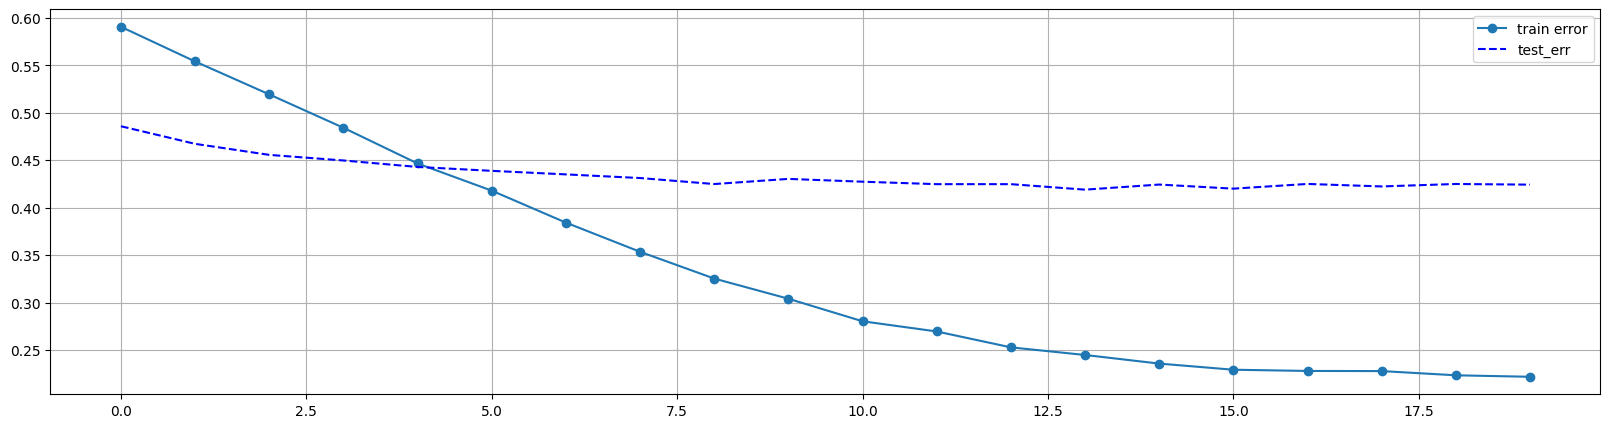

In [82]:
plt.figure(figsize=(20,5))
plt.plot(train_err , 'o-' , label='train error')
plt.plot(test_err , 'b--' , label='test_err')
plt.grid()
plt.legend()
plt.show()

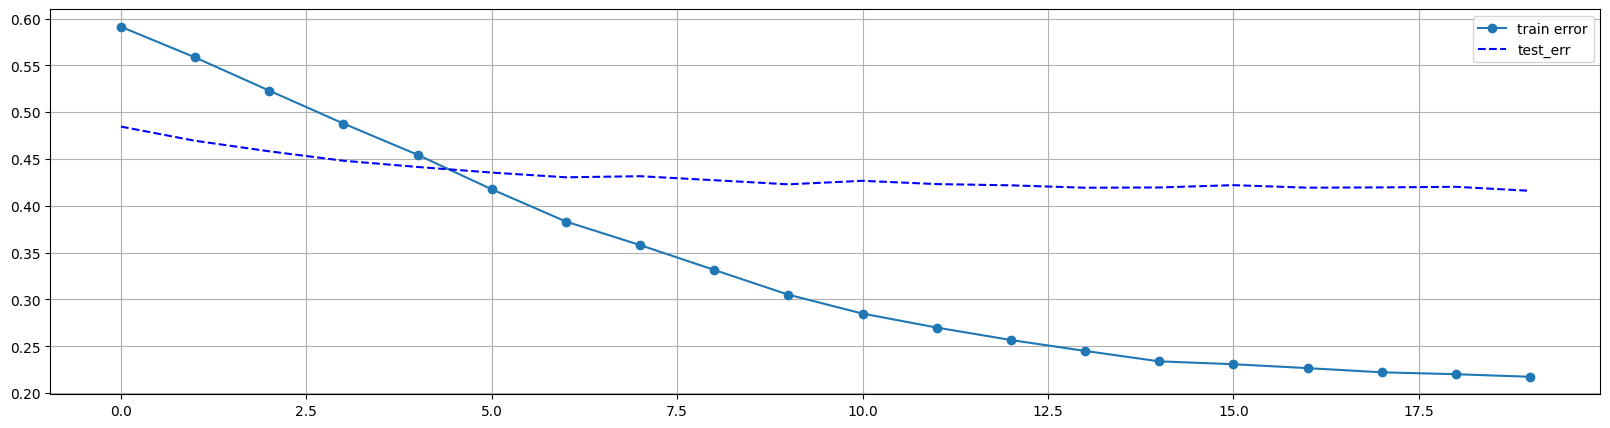

In [80]:
plt.figure(figsize=(20,5))
plt.plot(train_err , 'o-' , label='train error')
plt.plot(test_err , 'b--' , label='test_err')
plt.grid()
plt.legend()
plt.show()

In [84]:
rf_narx = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
rf_narx.fit(train_df[to_be_used_labels], train_df[target])

y_out = rf_narx.predict(train_df[to_be_used_labels])
rmse = np.sqrt(mean_squared_error(train_df[target], y_out))
train_err.append(rmse)

# 7. EVALUATE
y_pred = rf_narx.predict(test_df[to_be_used_labels])

rmse = np.sqrt(mean_squared_error(test_df[target], y_pred))
test_err.append(rmse)
mx_err = max_error(test_df[target], y_pred)

print(f"\n--- RESULTS ---")
print(f"RMSE: {rmse:.4f} Nm")
print(f"Max Error: {mx_err:.4f} Nm")

importances = rf_narx.feature_importances_
# importances
# len(predictors)
for i in range(len(to_be_used_labels)):
    if importances[i] > 0.01:
        print(f" '{to_be_used_labels[i]}', : {importances[i]}")



--- RESULTS ---
RMSE: 0.4385 Nm
Max Error: 5.7163 Nm
 'steering_spd', : 0.011347897644077612
 'torque_lag_1', : 0.15550908850803688
 'torque_lag_2', : 0.028817931942941955
 'pos_diff_1', : 0.011387684646531754
 'steering_acel_diff_3', : 0.011306316965573056
 'torque_smooth_10', : 0.025785857417996175
 'torque_smooth_5', : 0.5215705311174877


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, max_error

# 1. LOAD DATA
df = pd.read_csv('steering_data.csv')
df = df.dropna().reset_index(drop=True)

# 2. FEATURE ENGINEERING
# Base state variables
base_features = ['pos', 'steering_spd', 'steering_acel', 'roll', 'vx' , 'vy' , 'pitch' , 'yaw' , 'beta' , 'yaw_term' , 'v_speed' ]


lags = [1,2,3,4,5,10] 
memory_cols = []

# Loop includes 'torque' because we want Auto-Regression (using past torque to predict new torque)
for feat in base_features + ['torque']: 
    for lag in lags:
        col_name = f'{feat}_lag_{lag}'
        df[col_name] = df[feat].shift(lag) # <--- CRITICAL STEP
        memory_cols.append(col_name)

print(memory_cols)


df['vel_trend_10'] = df['steering_spd'].rolling(window=10).mean()
df['torque_smooth_10'] = df['torque_lag_1'].ewm(span=10).mean() # separately done to avoid leaking 
df['torque_smooth_5'] = df['torque_lag_1'].ewm(span=5).mean() # separately done to avoid leaking 

rols = [5 , 10]
for feat in base_features: 
    for lag in rols:
        col_name = f'{feat}_smooth_{lag}'
        df[col_name] = df[feat].ewm(span=lag).mean() # <--- CRITICAL STEP
        memory_cols.append(col_name)

print(memory_cols)

diff = [1 , 2, 3, 4]
for feat in base_features + ['torque_lag_1']: 
    for lag in diff:
        col_name = f'{feat}_diff_{lag}'
        df[col_name] = df[feat].diff(periods=lag) # <--- CRITICAL STEP
        memory_cols.append(col_name)


memory_cols.extend(['vel_trend_10', 'torque_smooth_10' , 'torque_smooth_5'])

df = df.dropna().reset_index(drop=True)

# 4. SPLIT (Chronological)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()


# 6. TRAIN GRADIENT BOOSTING (sklearn's XGBoost equivalent)
# Features: Physical + Raw Lags + Volatility + The New AR Feature
features = base_features + memory_cols
target = 'torque'

from scipy.stats import loguniform

train_err = []
test_err = [] 

for depth in range(3,15):
    for lr in [0.001 , 0.005, 0.01 , 0.05 , 0.1 , 0.5 , 1]:
        gb = GradientBoostingRegressor(n_estimators=100, learning_rate=lr, max_depth=depth)
        gb.fit(train_df[features], train_df[target])

        y_out = gb.predict(train_df[features])

        rmse = np.sqrt(mean_squared_error(train_df[target], y_out))
        train_err.append(rmse)
        
        # 7. PREDICT & EVALUATE
        y_pred = gb.predict(test_df[features])

        rmse = np.sqrt(mean_squared_error(test_df[target], y_pred))
        test_err.append(rmse)
        mx_err = max_error(test_df[target], y_pred)

        print(f"--- Gradient Boosting + AR Feature Results ---")
        print(f"RMSE: {rmse:.4f} Nm")
        print(f"Max Error: {mx_err:.4f} Nm")

plt.figure(figsize=(20,5))
plt.plot(train_err , 'o-' , label='train error')
plt.plot(test_err , 'b--' , label='test_err')
plt.grid()
plt.legend()
plt.show()

['pos_lag_1', 'pos_lag_2', 'pos_lag_3', 'pos_lag_4', 'pos_lag_5', 'pos_lag_10', 'steering_spd_lag_1', 'steering_spd_lag_2', 'steering_spd_lag_3', 'steering_spd_lag_4', 'steering_spd_lag_5', 'steering_spd_lag_10', 'steering_acel_lag_1', 'steering_acel_lag_2', 'steering_acel_lag_3', 'steering_acel_lag_4', 'steering_acel_lag_5', 'steering_acel_lag_10', 'roll_lag_1', 'roll_lag_2', 'roll_lag_3', 'roll_lag_4', 'roll_lag_5', 'roll_lag_10', 'vx_lag_1', 'vx_lag_2', 'vx_lag_3', 'vx_lag_4', 'vx_lag_5', 'vx_lag_10', 'vy_lag_1', 'vy_lag_2', 'vy_lag_3', 'vy_lag_4', 'vy_lag_5', 'vy_lag_10', 'pitch_lag_1', 'pitch_lag_2', 'pitch_lag_3', 'pitch_lag_4', 'pitch_lag_5', 'pitch_lag_10', 'yaw_lag_1', 'yaw_lag_2', 'yaw_lag_3', 'yaw_lag_4', 'yaw_lag_5', 'yaw_lag_10', 'beta_lag_1', 'beta_lag_2', 'beta_lag_3', 'beta_lag_4', 'beta_lag_5', 'beta_lag_10', 'yaw_term_lag_1', 'yaw_term_lag_2', 'yaw_term_lag_3', 'yaw_term_lag_4', 'yaw_term_lag_5', 'yaw_term_lag_10', 'v_speed_lag_1', 'v_speed_lag_2', 'v_speed_lag_3', 'v

KeyboardInterrupt: 

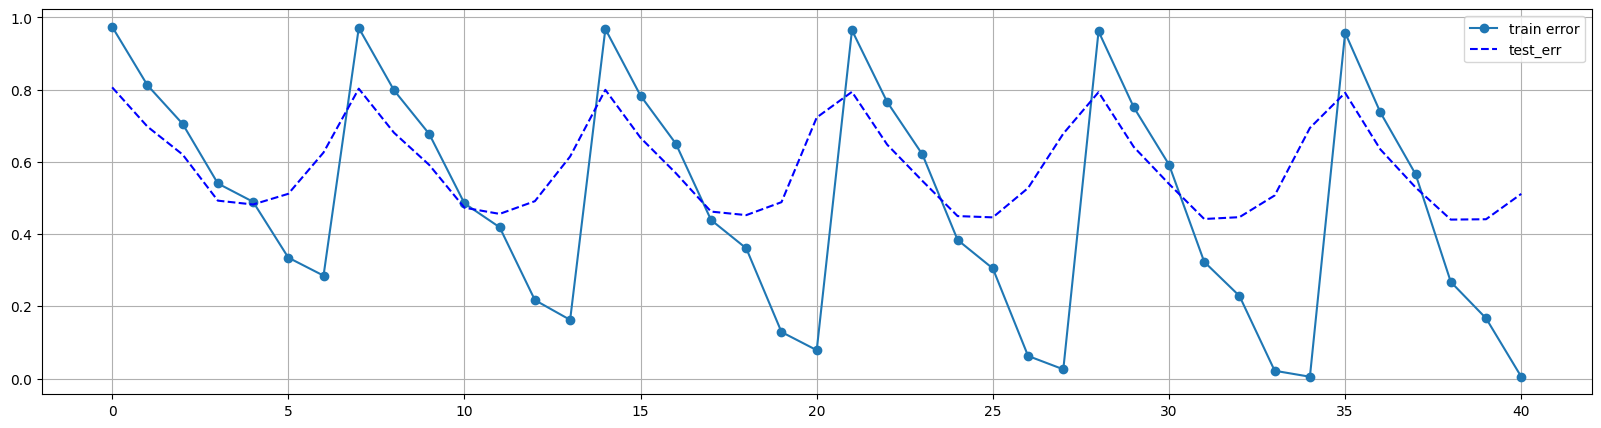

In [87]:
plt.figure(figsize=(20,5))
plt.plot(train_err , 'o-' , label='train error')
plt.plot(test_err , 'b--' , label='test_err')
plt.grid()
plt.legend()
plt.show()

Best RMSE: 0.4262560134078455
Best params: {'max_depth': np.int64(11), 'learning_rate': 0.03760504619418188}


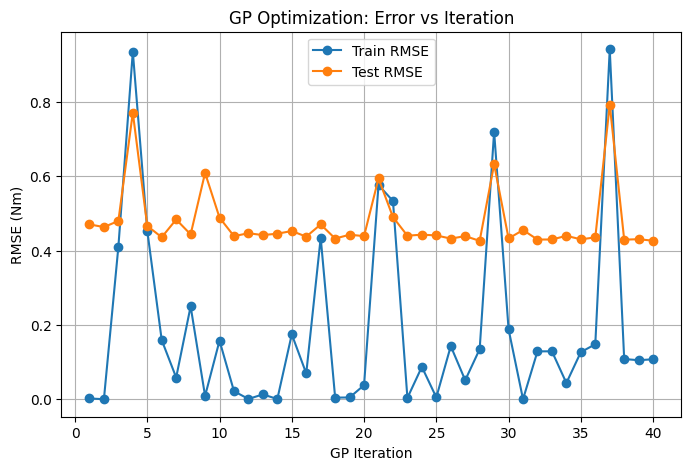

In [93]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
import numpy as np

space = [
    Integer(3, 14, name='max_depth'),
    Real(1e-3, 1.0, prior='log-uniform', name='learning_rate')
]

train_err = []
test_err = []
iters = []

@use_named_args(space)
def objective(max_depth, learning_rate):
    gb = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=0
    )
    gb.fit(train_df[features], train_df[target])

    # Train error
    y_tr = gb.predict(train_df[features])
    tr_rmse = np.sqrt(mean_squared_error(train_df[target], y_tr))

    # Test error
    y_te = gb.predict(test_df[features])
    te_rmse = np.sqrt(mean_squared_error(test_df[target], y_te))

    train_err.append(tr_rmse)
    test_err.append(te_rmse)
    iters.append(len(train_err))

    return te_rmse   # GP always minimizes this


res = gp_minimize(
    objective,
    space,
    n_calls=40,        # ~40–50 is usually enough
    n_initial_points=10,
    random_state=0
)

print("Best RMSE:", res.fun)
print("Best params:", dict(zip(['max_depth','learning_rate'], res.x)))

plt.figure(figsize=(8,5))
plt.plot(iters, train_err, label='Train RMSE', marker='o')
plt.plot(iters, test_err, label='Test RMSE', marker='o')
plt.xlabel('GP Iteration')
plt.ylabel('RMSE (Nm)')
plt.title('GP Optimization: Error vs Iteration')
plt.legend()
plt.grid()
plt.show()



In [94]:
best_depth, best_lr = res.x

gb_best = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=best_depth,
    learning_rate=best_lr,
    random_state=0
)
gb_best.fit(train_df[features], train_df[target])


GradientBoostingRegressor(learning_rate=0.03760504619418188,
                          max_depth=np.int64(11), random_state=0)

In [96]:
import joblib

joblib.dump(gb_best, "boost_tree_model.joblib")

['boost_tree_model.joblib']

## Noise Vairience Bias

Frequency domain 

Assuming the signal is smooth - wts the err of signal from its own moving average`

Sampling Rate: 10.0 Hz
type <class 'numpy.ndarray'> and freq = [6.46593890e-13  -0.j         6.54186522e+02-143.5748961j
 4.43082887e+02-172.24354539j ... 3.67580447e+02+390.50180707j
 4.43082887e+02+172.24354539j 6.54186522e+02+143.5748961j ]
Estimated Noise Level (RMS): 0.1960 Nm


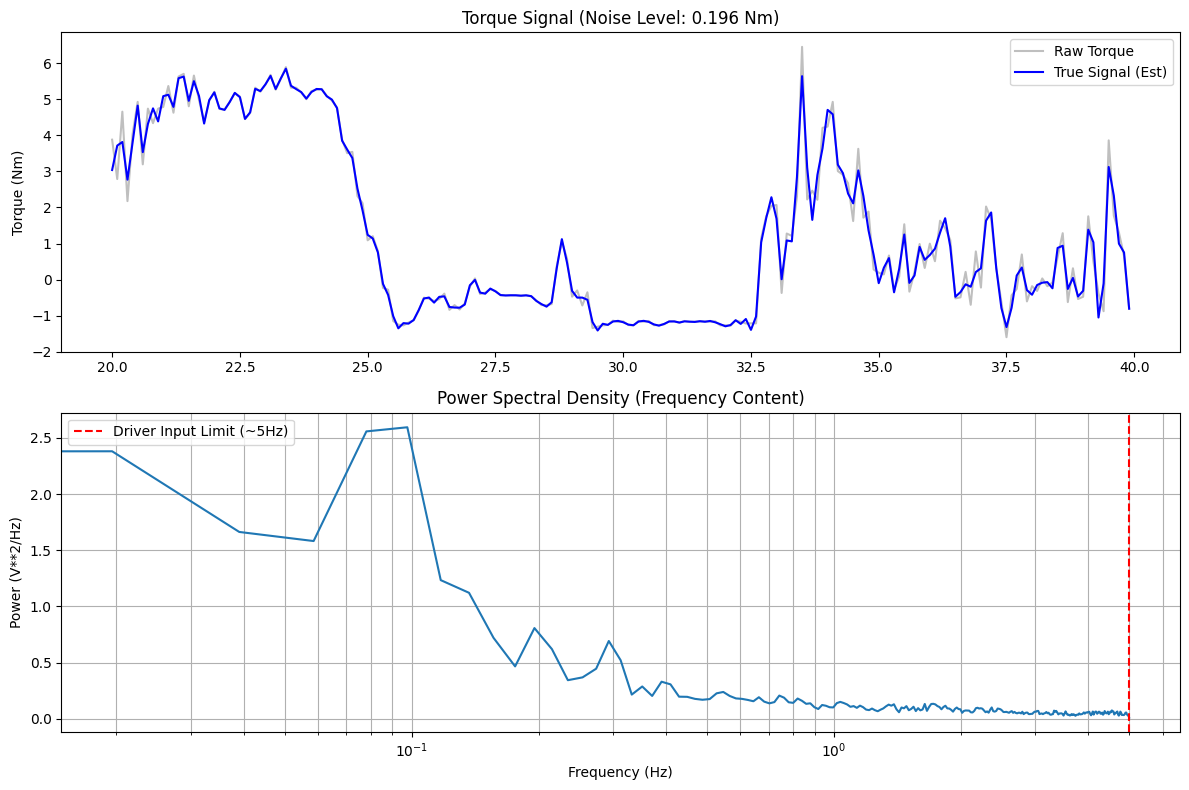

In [ ]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from scipy.fft import fft , ifft
import matplotlib.pyplot as plt

# 1. Load Data & Parse Time
df = pd.read_csv('steering_data.csv')

# Convert "0 days 00:00:00" format to total seconds
df['seconds'] = pd.to_timedelta(df['time']).dt.total_seconds()

# PSD
dt = df['seconds'].diff().mean()
fs = 1.0 / dt
print(f"Sampling Rate: {fs:.1f} Hz")

x = df.torque.to_numpy()
freqs, psd = signal.welch(x, fs=fs, nperseg=512)


f = fft(x)
print(f"type {type(f)} and freq = {f}")


# Rolling mean noise 
window_size = 3
# df['torque_smooth'] = df['torque'].rolling(window=window_size, center=True).mean()
# df['noise'] = df['torque'] - df['torque_smooth']

# Low pass filter
fc = 4 # [0.01 , 0.1]  # Hz (human steering bandwidth)
# Nq freq = fs/ 2 -- which is 5  -- so we are barely able to capture steering dynamics at 5Hz 
b, a = signal.butter(2, fc/(fs/2), btype='low')  # bandstop , bandpass , high , low
df['torque_smooth'] = signal.filtfilt(b, a, df['torque'])
df['noise'] = df['torque'] - df['torque_smooth']

# The Standard Deviation of the noise is your "Noise Level"
noise_level = df['noise'].std()
print(f"Estimated Noise Level (RMS): {noise_level:.4f} Nm")



# --- VISUALIZATION ---
plt.figure(figsize=(12, 8))

df = df.iloc[200:400]

# Plot 1: Raw vs Smoothed
plt.subplot(2, 1, 1)
plt.plot(df['seconds'], df['torque'], label='Raw Torque', alpha=0.5, color='gray')
plt.plot(df['seconds'], df['torque_smooth'], label='True Signal (Est)', color='blue')
plt.title(f'Torque Signal (Noise Level: {noise_level:.3f} Nm)')
plt.legend()
plt.ylabel('Torque (Nm)')

# Plot 2: Power Spectral Density (PSD)
plt.subplot(2, 1, 2)
plt.semilogx(freqs, psd)
plt.title('Power Spectral Density (Frequency Content)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V**2/Hz)')
plt.grid(True, which='both')
plt.axvline(x=5, color='r', linestyle='--', label='Driver Input Limit (~5Hz)')
plt.legend()


plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Load & Prep Data
df = pd.read_csv('steering_data.csv')
# features = ['vx', 'vy', 'vz', 'yaw_rate', 'steering_vel', 'steering_acel']
features = ['pos', 'steering_spd', 'steering_acel', 'roll', 'vx' , 'vy' , 'pitch' , 'yaw' , 'v_speed' ]
target = 'torque'

X = df[features]
y = df[target]

# 2. Subsample (Crucial for GPR speed)
# Standard GPR struggles with >2000 points. We'll sample 1000 for this demo.
if len(X) > 1000:
    df_sample = df.sample(n=1000, random_state=42)
    X = df_sample[features]
    y = df_sample[target]

# 3. Scaling (Mandatory for GPR)
# GPR is distance-based; if one feature is 1000x larger than another, it breaks.
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 4. Define Kernel
kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

# 5. Fit Model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
gpr.fit(X_train, y_train)

# 6. Predict with Uncertainty
y_pred_scaled, y_std_scaled = gpr.predict(X_test, return_std=True)

# Convert back to original units
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
# Scale standard deviation (multiply by scale_, don't use inverse_transform)
y_std = y_std_scaled * scaler_y.scale_[0]

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")
print(f"Learned Kernel: {gpr.kernel_}")

MSE: 0.6010
R2: 0.4986
Learned Kernel: 0.861**2 * RBF(length_scale=0.135) + WhiteKernel(noise_level=0.0048)


Text(0.5, 1.0, 'GPR: Actual vs Predicted (R2=0.499)')

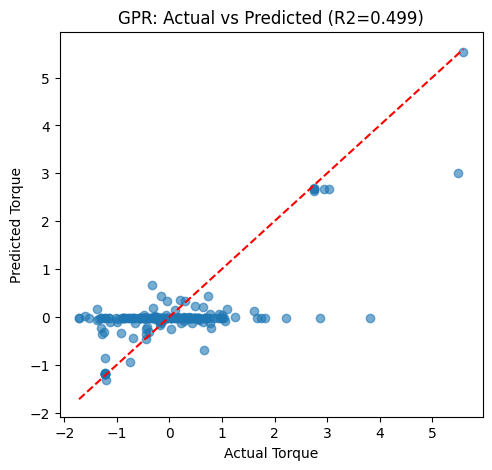

In [51]:
plt.figure(figsize=(12, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Torque')
plt.ylabel('Predicted Torque')
plt.title(f'GPR: Actual vs Predicted (R2={r2:.3f})')

In [71]:
import time

from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Load & Prep Data
df = pd.read_csv('steering_data.csv')
# features = ['vx', 'vy', 'vz', 'yaw_rate', 'steering_vel', 'steering_acel']
features = ['pos', 'steering_spd', 'steering_acel', 'roll', 'vx' , 'vy' , 'pitch' , 'yaw' ]
target = 'torque'

X = df[features]
y = df[target]

# 2. Subsample (Crucial for GPR speed)
# Standard GPR struggles with >2000 points. We'll sample 1000 for this demo.
if len(X) > 1000:
    df_sample = df.sample(n=1000, random_state=42)
    X = df_sample[features]
    y = df_sample[target]

# 3. Scaling (Mandatory for GPR)
# GPR is distance-based; if one feature is 1000x larger than another, it breaks.
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# pairwise.rbf_kernel
from sklearn.metrics.pairwise import pairwise_kernels
# kernel_ridge =  pairwise_kernels(X_train, y_train.reshape(-1,1), metric='rbf') #KernelRidge(kernel=ExpSineSquared())

# start_time = time.time()
# kernel_ridge.fit(X_train, y_train)
# print(
#     f"Fitting KernelRidge with default kernel: {time.time() - start_time:.3f} seconds"
# )

from scipy.stats import loguniform

from sklearn.model_selection import RandomizedSearchCV

kernel_ridge = KernelRidge(kernel='polynomial')

param_distributions = {
    "degree": [0.25 , 0.5 ,1.5, 2 ,3],
    "alpha": loguniform(1e-2, 1e2),
    # "kernel__periodicity": loguniform(1e0, 1e1),
}
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
)
start_time = time.time()
kernel_ridge_tuned.fit(X_train, y_train)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

Time for KernelRidge fitting: 123.040 seconds


In [72]:
print(f"best param {kernel_ridge_tuned.best_params_}")
start_time = time.time()
predictions_kr = kernel_ridge_tuned.predict(X_train)
print(f"Time for KernelRidge predict: {time.time() - start_time:.3f} seconds")

best param {'alpha': np.float64(14.566682453039137), 'degree': 3}
Time for KernelRidge predict: 0.021 seconds


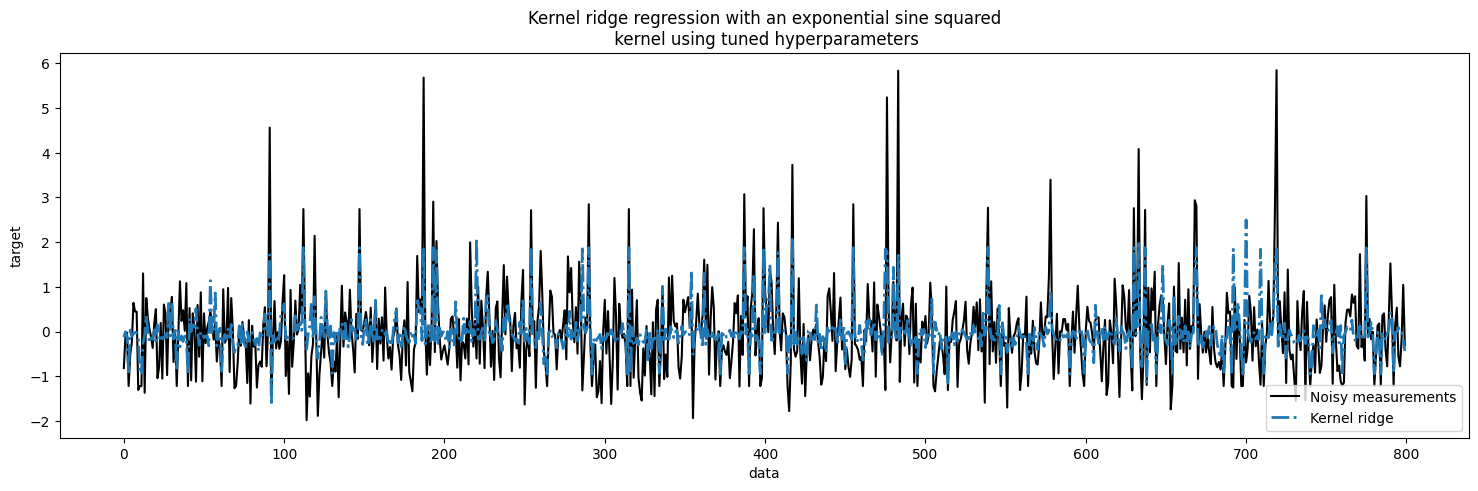

In [73]:
plt.figure(figsize=(40, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.plot(
    y_train,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters"
)